# FAILED SURGE: Analyzing Beijing’s Disinformation Campaign Surge On Twitter

This is the third in a series of notebooks analysing China's state disinformation campaign against the Hong Kong protests, this time focusing on a sharp spike in activity and fake account creation from May to end-July 2019. This "surge" is among the most interesting findings in the [second tranche of Chinese state troll tweets released by Twitter on Sept 20 2019](https://blog.twitter.com/en_us/topics/company/2019/info-ops-disclosure-data-september-2019.html). Twitter first announced and [released the initial trove of Chinese troll tweets on Aug 19 2019](https://blog.twitter.com/en_us/topics/company/2019/information_operations_directed_at_Hong_Kong.html).

Political tensions have been rising sharply in Hong Kong this year, prompting Beijing to step up its disinformation campaign on social media. I would argue, based on my analysis of the second tranche of Chinese tweets, that this spike in activity is one of the key reasons that could have led to the uncovering of Beijing's clandestine operation.

I also briefly compare the text of the tweets in the two troll sets to see if there's been a change in narrative tone or focus. My earlier Medium posts on the subject are [here](https://towardsdatascience.com/target-hk-a-quick-dive-into-chinas-disinformation-campaign-on-twitter-2b64ab9feb1a) and [here](https://towardsdatascience.com/hkprotest-visualizing-state-troll-tweets-from-chinas-disinformation-campaign-1dc4bcab437d).

PS: This notebook is computationally expensive to run due to the heavy use of interactive charts, which are available separately in the "charts" folder in this repo. My earlier analysis of the first set of Chinese state troll tweets are detailed in notebook 1.0 and notebook 2.0 series.

In [1]:
import jieba, jieba.analyse
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import plotly
import plotly_express as px
import plotly.graph_objects as go
import plotly.offline as py
import re
import spacy
import scattertext as st
import seaborn as sns
import squarify

from datetime import datetime
from IPython.display import IFrame
from IPython.core.display import display, HTML
from plotly.subplots import make_subplots 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.stats import rankdata, hmean, norm
from scattertext import CorpusFromParsedDocuments
from scattertext import chinese_nlp
from scattertext import produce_scattertext_explorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from yellowbrick.text import FreqDistVisualizer

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
pd.set_option('display.max_columns', 40)

# 1. DATA-PREPROCESSING
My approach in this section is similar to the pre-processing steps that I had taken in earlier notebooks to prepare the data for analysis and visualisation.

In [3]:
# The raw CSV files are NOT in this repo. Download directly from Twitter using the links above
# Twitter released raw1 and raw2 on Aug19
raw1 = pd.read_csv('../data/china_082019_1_tweets_csv_hashed.csv') # 762 Mb
raw2 = pd.read_csv('../data/china_082019_2_tweets_csv_hashed.csv') # 808 Mb

# Twitter released raw3-5 on Sept 20
raw3 = pd.read_csv('../data/china_082019_3_tweets_csv_hashed_part1.csv') # 1.21 Gb
raw4 = pd.read_csv('../data/china_082019_3_tweets_csv_hashed_part2.csv') # 1.51 Gb
raw5 = pd.read_csv('../data/china_082019_3_tweets_csv_hashed_part3.csv') # 1.32 Gb

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (15,19,30) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (1,15,30) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
# My approach here is to compare the two sets of tweets, so they were concated separately
# Feel free to concat CSVs 1-5 if you wish to analyse the 2 tranches together
raw_aug = pd.concat([raw1, raw2])
raw_sept = pd.concat([raw3, raw4, raw5])

In [5]:
raw_aug.shape, raw_sept.shape

((3614909, 31), (10241545, 31))

The 2nd tranche of tweets is nearly 3 times bigger than the first, containing 10.2 million tweets Vs 3.6 million rows in the first tranche.

In [6]:
# Converting account creation timings to HK time, and extracting year-month-day-hour cols
raw_aug['account_creation_date'] = pd.to_datetime(raw_aug['account_creation_date'], yearfirst=True)
raw_aug['year_of_account_creation'] = raw_aug['account_creation_date'].dt.year
raw_aug['month_of_account_creation'] = raw_aug['account_creation_date'].dt.month
raw_aug['day_of_account_creation'] = raw_aug['account_creation_date'].dt.day

raw_sept['account_creation_date'] = pd.to_datetime(raw_sept['account_creation_date'], yearfirst=True)
raw_sept['year_of_account_creation'] = raw_sept['account_creation_date'].dt.year
raw_sept['month_of_account_creation'] = raw_sept['account_creation_date'].dt.month
raw_sept['day_of_account_creation'] = raw_sept['account_creation_date'].dt.day

In [7]:
# Converting timing of tweets to HK time, and extracting year-month-day-hour cols
raw_aug['tweet_time'] = pd.to_datetime(raw_aug['tweet_time'])
raw_aug['tweet_time'] = raw_aug['tweet_time'].dt.tz_localize('GMT').dt.tz_convert('Hongkong')
raw_aug['tweet_year'] = raw_aug['tweet_time'].dt.year
raw_aug['tweet_month'] = raw_aug['tweet_time'].dt.month
raw_aug['tweet_day'] = raw_aug['tweet_time'].dt.day
raw_aug['tweet_hour'] = raw_aug['tweet_time'].dt.hour

raw_sept['tweet_time'] = pd.to_datetime(raw_sept['tweet_time'])
raw_sept['tweet_time'] = raw_sept['tweet_time'].dt.tz_localize('GMT').dt.tz_convert('Hongkong')
raw_sept['tweet_year'] = raw_sept['tweet_time'].dt.year
raw_sept['tweet_month'] = raw_sept['tweet_time'].dt.month
raw_sept['tweet_day'] = raw_sept['tweet_time'].dt.day
raw_sept['tweet_hour'] = raw_sept['tweet_time'].dt.hour

In [8]:
# Dropping columns that are not needed for this analysis
raw_aug = raw_aug.drop(
    columns=[
        "tweetid",
        "userid",
        "user_profile_url",
        "tweet_client_name",
        "in_reply_to_tweetid",
        "in_reply_to_userid",
        "quoted_tweet_tweetid",
        "is_retweet",
        "retweet_userid",
        "retweet_tweetid",
        "quote_count",
        "reply_count",
        "urls",
        "user_mentions",
        "poll_choices",
        "latitude", # no values in dataset beyond absent/present 
        "longitude", # no values in dataset beyond absent/present
        "like_count",
        "retweet_count"
    ]
)


raw_sept = raw_sept.drop(
    columns=[
        "tweetid",
        "userid",
        "user_profile_url",
        "tweet_client_name",
        "in_reply_to_tweetid",
        "in_reply_to_userid",
        "quoted_tweet_tweetid",
        "is_retweet",
        "retweet_userid",
        "retweet_tweetid",
        "quote_count",
        "reply_count",
        "urls",
        "user_mentions",
        "poll_choices",
        "latitude", # no values in dataset beyond absent/present 
        "longitude", # no values in dataset beyond absent/present
        "like_count",
        "retweet_count"
    ]
)

In [9]:
raw_aug.head()

user_display_name user_screen_name user_reported_location  \
0        The Flecha        nessniven      Republic of Korea   
1        The Flecha        nessniven      Republic of Korea   
2        The Flecha        nessniven      Republic of Korea   
3        The Flecha        nessniven      Republic of Korea   
4        The Flecha        nessniven      Republic of Korea   

                            user_profile_description  follower_count  \
0  When you see Jair Bolsonaro and his program of...          100847   
1  When you see Jair Bolsonaro and his program of...          100847   
2  When you see Jair Bolsonaro and his program of...          100847   
3  When you see Jair Bolsonaro and his program of...          100847   
4  When you see Jair Bolsonaro and his program of...          100847   

   following_count account_creation_date account_language tweet_language  \
0            31752            2010-10-22               en             pt   
1            31752            2010-10-22               en             pt   
2            31752            2010-10-22               en             pt   
3            31752            2010-10-22               en             pt   
4            31752            2010-10-22               en            NaN   

                                          tweet_text  \
0  segui o @instagranzin e ganhei 89 seguidores ♥...   
1  10 COISAS QUE VOCÊ NÃO SABE SOBRE A VAGINA (a ...   
2  QUE LEGAL! Segui o @AsPositlvidades e ele me i...   
3  Cantora de funk de 7 anos gera polemica na int...   
4  QUER GANHAR SEGUIDORES FACIL? A QUANTIL QUE QU...   

                 tweet_time hashtags  year_of_account_creation  \
0 2014-02-20 09:08:00+08:00      NaN                      2010   
1 2015-03-31 07:17:00+08:00       []                      2010   
2 2015-04-01 04:08:00+08:00       []                      2010   
3 2015-03-25 00:21:00+08:00       []                      2010   
4 2012-05-06 13:26:00+08:00      NaN                      2010   

   month_of_account_creation  day_of_account_creation  tweet_year  \
0                         10                       22        2014   
1                         10                       22        2015   
2                         10                       22        2015   
3                         10                       22        2015   
4                         10                       22        2012   

   tweet_month  tweet_day  tweet_hour  
0            2         20           9  
1            3         31           7  
2            4          1           4  
3            3         25           0  
4            5          6          13

In [10]:
raw_sept.tail()

user_display_name user_screen_name user_reported_location  \
2875329      七七100%follow     qiqixianghui                     凼仔   
2875330      七七100%follow     qiqixianghui                     凼仔   
2875331      七七100%follow     qiqixianghui                     凼仔   
2875332              西单青年         fanqinuo          Michigan, USA   
2875333              西单青年         fanqinuo          Michigan, USA   

                                  user_profile_description  follower_count  \
2875329                                                NaN           28647   
2875330                                                NaN           28647   
2875331                                                NaN           28647   
2875332  中國人的性情是總喜歡調和折中的，譬如你說，這屋子太暗，須在這裡開一個窗，大家一定不允許的。但...           53628   
2875333  中國人的性情是總喜歡調和折中的，譬如你說，這屋子太暗，須在這裡開一個窗，大家一定不允許的。但...           53628   

         following_count account_creation_date account_language  \
2875329            12948            2012-07-25            zh-cn   
2875330            12948            2012-07-25            zh-cn   
2875331            12948            2012-07-25            zh-cn   
2875332            11948            2010-12-05            zh-cn   
2875333            11948            2010-12-05            zh-cn   

        tweet_language                                         tweet_text  \
2875329             zh  鱼籽烧豆腐\n\n材料：鱼籽，豆腐，葱姜蒜末，花椒，酱油，黄酒，醋，黑胡椒，蘑菇精 http...   
2875330             zh   7  烤箱提前200度预热，预热完成提示音响后烤盘放入中层。\n\n8  烘烤15分钟左右即可。   
2875331             zh         大理洱海边~ https://t.co/jMddxc9tcu 来自 @YouTube   
2875332             zh  #健康 爱发火的朋友多按少府穴，发怒伤身，当你有发怒冲动时，握紧拳头，小指尖处就是少府穴。按...   
2875333             zh  吴哥窟（Angkor Wat）位于柬埔寨西北部，被称作柬埔寨国宝，是吴哥古迹中保存最完好的庙...   

                       tweet_time hashtags  year_of_account_creation  \
2875329 2019-05-26 22:53:00+08:00       []                      2012   
2875330 2019-04-18 08:37:00+08:00       []                      2012   
2875331 2018-05-22 20:09:00+08:00       []                      2012   
2875332 2018-09-01 09:24:00+08:00   ['健康']                      2010   
2875333 2018-12-04 10:05:00+08:00       []                      2010   

         month_of_account_creation  day_of_account_creation  tweet_year  \
2875329                          7                       25        2019   
2875330                          7                       25        2019   
2875331                          7                       25        2018   
2875332                         12                        5        2018   
2875333                         12                        5        2018   

         tweet_month  tweet_day  tweet_hour  
2875329            5         26          22  
2875330            4         18           8  
2875331            5         22          20  
2875332            9          1           9  
2875333           12          4          10

# 2. BROAD COMPARISON OF 2 TRANCHES OF CHINESE STATE TROLL TWEETS
Let's compare the two sets at the broad level, before filtering down to specific categories that might yield more interesting insights.

In [11]:
print(
    "Number of unique users in Aug troll set:",
    raw_aug["user_screen_name"].nunique(),
    " | ",
    "Number of unique users in Sept troll set:",
    raw_sept["user_screen_name"].nunique(),
)

print(
    "Number of unique user reported locations in Aug troll set:",
    raw_aug["user_reported_location"].nunique(),
    " | ",
    "Number of unique user reported locations in Sept troll set:",
    raw_sept["user_reported_location"].nunique(),
)

print(
    "Number of unique user creation dates in Aug troll set:",
    raw_aug["account_creation_date"].nunique(),
    " | ",
    "Number of unique user creation dates in Sept troll set:",
    raw_sept["account_creation_date"].nunique(),
)

print(
    "Number of unique account languages in Aug troll set:",
    raw_aug["account_language"].nunique(),
    " | ",
    "Number of unique account languages in Sept troll set:",
    raw_sept["account_language"].nunique(),
)

print(
    "Number of unique tweet languages in Aug troll set:",
    raw_aug["tweet_language"].nunique(),
    " | ",
    "Number of unique tweet languages in Sept troll set:",
    raw_sept["tweet_language"].nunique(),
)

print(
    "Number of unique tweets in Aug troll set:",
    raw_aug["tweet_text"].nunique(),
    " | ",
    "Number of unique tweets in Sept troll set:",
    raw_sept["tweet_text"].nunique(),
)


Number of unique users in Aug troll set: 890  |  Number of unique users in Sept troll set: 4301
Number of unique user reported locations in Aug troll set: 178  |  Number of unique user reported locations in Sept troll set: 574
Number of unique user creation dates in Aug troll set: 427  |  Number of unique user creation dates in Sept troll set: 1044
Number of unique account languages in Aug troll set: 9  |  Number of unique account languages in Sept troll set: 12
Number of unique tweet languages in Aug troll set: 59  |  Number of unique tweet languages in Sept troll set: 62
Number of unique tweets in Aug troll set: 3236991  |  Number of unique tweets in Sept troll set: 8103989


<img src = "../charts/ch_trolls_augvsept.jpg">

Rustled up this chart in a hurry on Google Sheets. You can download it from the "charts" folder in the repo. Will try a divergent bar chart at some point.

The far higher number of unique users in the 2nd tranche of tweets offer the first major clue as to where to start digging - in this case, the account creation date. The state trolls behind Beijing's campaign could have done one of 2 things: acquire more existing accounts, or create new ones in large numbers. The latter is a major tell-tale sign that would certainly get attention at Twitter, since the service is blocked in China.

## 2.1 ANALYSIS AND COMPARISON OF TROLL ACCOUNT CREATION DATES

In [12]:
aug_accounts = (
    raw_aug.groupby(["year_of_account_creation", "month_of_account_creation"])
    .user_screen_name.nunique()
    .sort_index(ascending=False)
    .head(20)
)

aug_accounts = pd.DataFrame(
    aug_accounts.reset_index().rename(
        columns={"index": "Year", 0: "Month", 1: "No of troll accounts created"}
    )
)
aug_accounts.columns = ["Year", "Month", "No of troll accounts created"]
aug_accounts

Year  Month  No of troll accounts created
0   2019      5                             3
1   2019      4                             5
2   2019      3                             2
3   2019      2                            12
4   2019      1                             7
5   2018     12                            10
6   2018     11                             2
7   2018     10                             8
8   2018      8                             1
9   2018      7                            14
10  2018      4                             5
11  2018      3                             8
12  2018      2                             2
13  2018      1                             2
14  2017     12                             5
15  2017     11                            46
16  2017     10                            79
17  2017      9                            20
18  2017      8                           238
19  2017      7                            11

In [13]:
sept_accounts = raw_sept.groupby(
    ["year_of_account_creation", "month_of_account_creation"]
).user_screen_name.nunique().sort_index(ascending=False).head(20)

sept_accounts = pd.DataFrame(
    sept_accounts.reset_index().rename(
        columns={"index": "Year", 0: "Month", 1: "No of troll accounts created"}
    )
)
sept_accounts.columns = ["Year", "Month", "No of troll accounts created"]
sept_accounts

Year  Month  No of troll accounts created
0   2019      8                            65
1   2019      7                           822
2   2019      6                           816
3   2019      5                           617
4   2019      4                           294
5   2019      3                           223
6   2019      2                           254
7   2019      1                           102
8   2018     12                            63
9   2018     11                            45
10  2018     10                            39
11  2018      9                            38
12  2018      8                            16
13  2018      7                            28
14  2018      6                            19
15  2018      5                            15
16  2018      4                            16
17  2018      3                             6
18  2018      2                            13
19  2018      1                            23

## NOTE:
When Twitter released the first tranche of Chinese state troll tweets on Aug 19 2019, it wasn't clear how this network got exposed, particularly since most of the accounts were created in August 2017 or earlier.

Things become much clearer now that we have the 2nd tranche of Chinese troll tweets. As the 2nd chart shows, a suspiciously large number of new accounts were created in 2019, with a particularly sharp spike from May.

In fact, the 2,320 accounts created between May and August 2019 accounted for nearly 54% of the total number of accounts in the second tranche of 4,301 troll accounts. Beijing likely felt that it had to step up its campaign in the face of escalating tension and protests in Hong Kong. But this likely backfired as there's no way Twitter's monitoring team wouldn't have noticed a suspiciously high number of accounts *in a country that has banned Twitter* (Twitter said the accounts were ["based in the PRC"](https://blog.twitter.com/en_us/topics/company/2019/info-ops-disclosure-data-september-2019.html)).

Charts spell out the difference in account creation dates clearly.

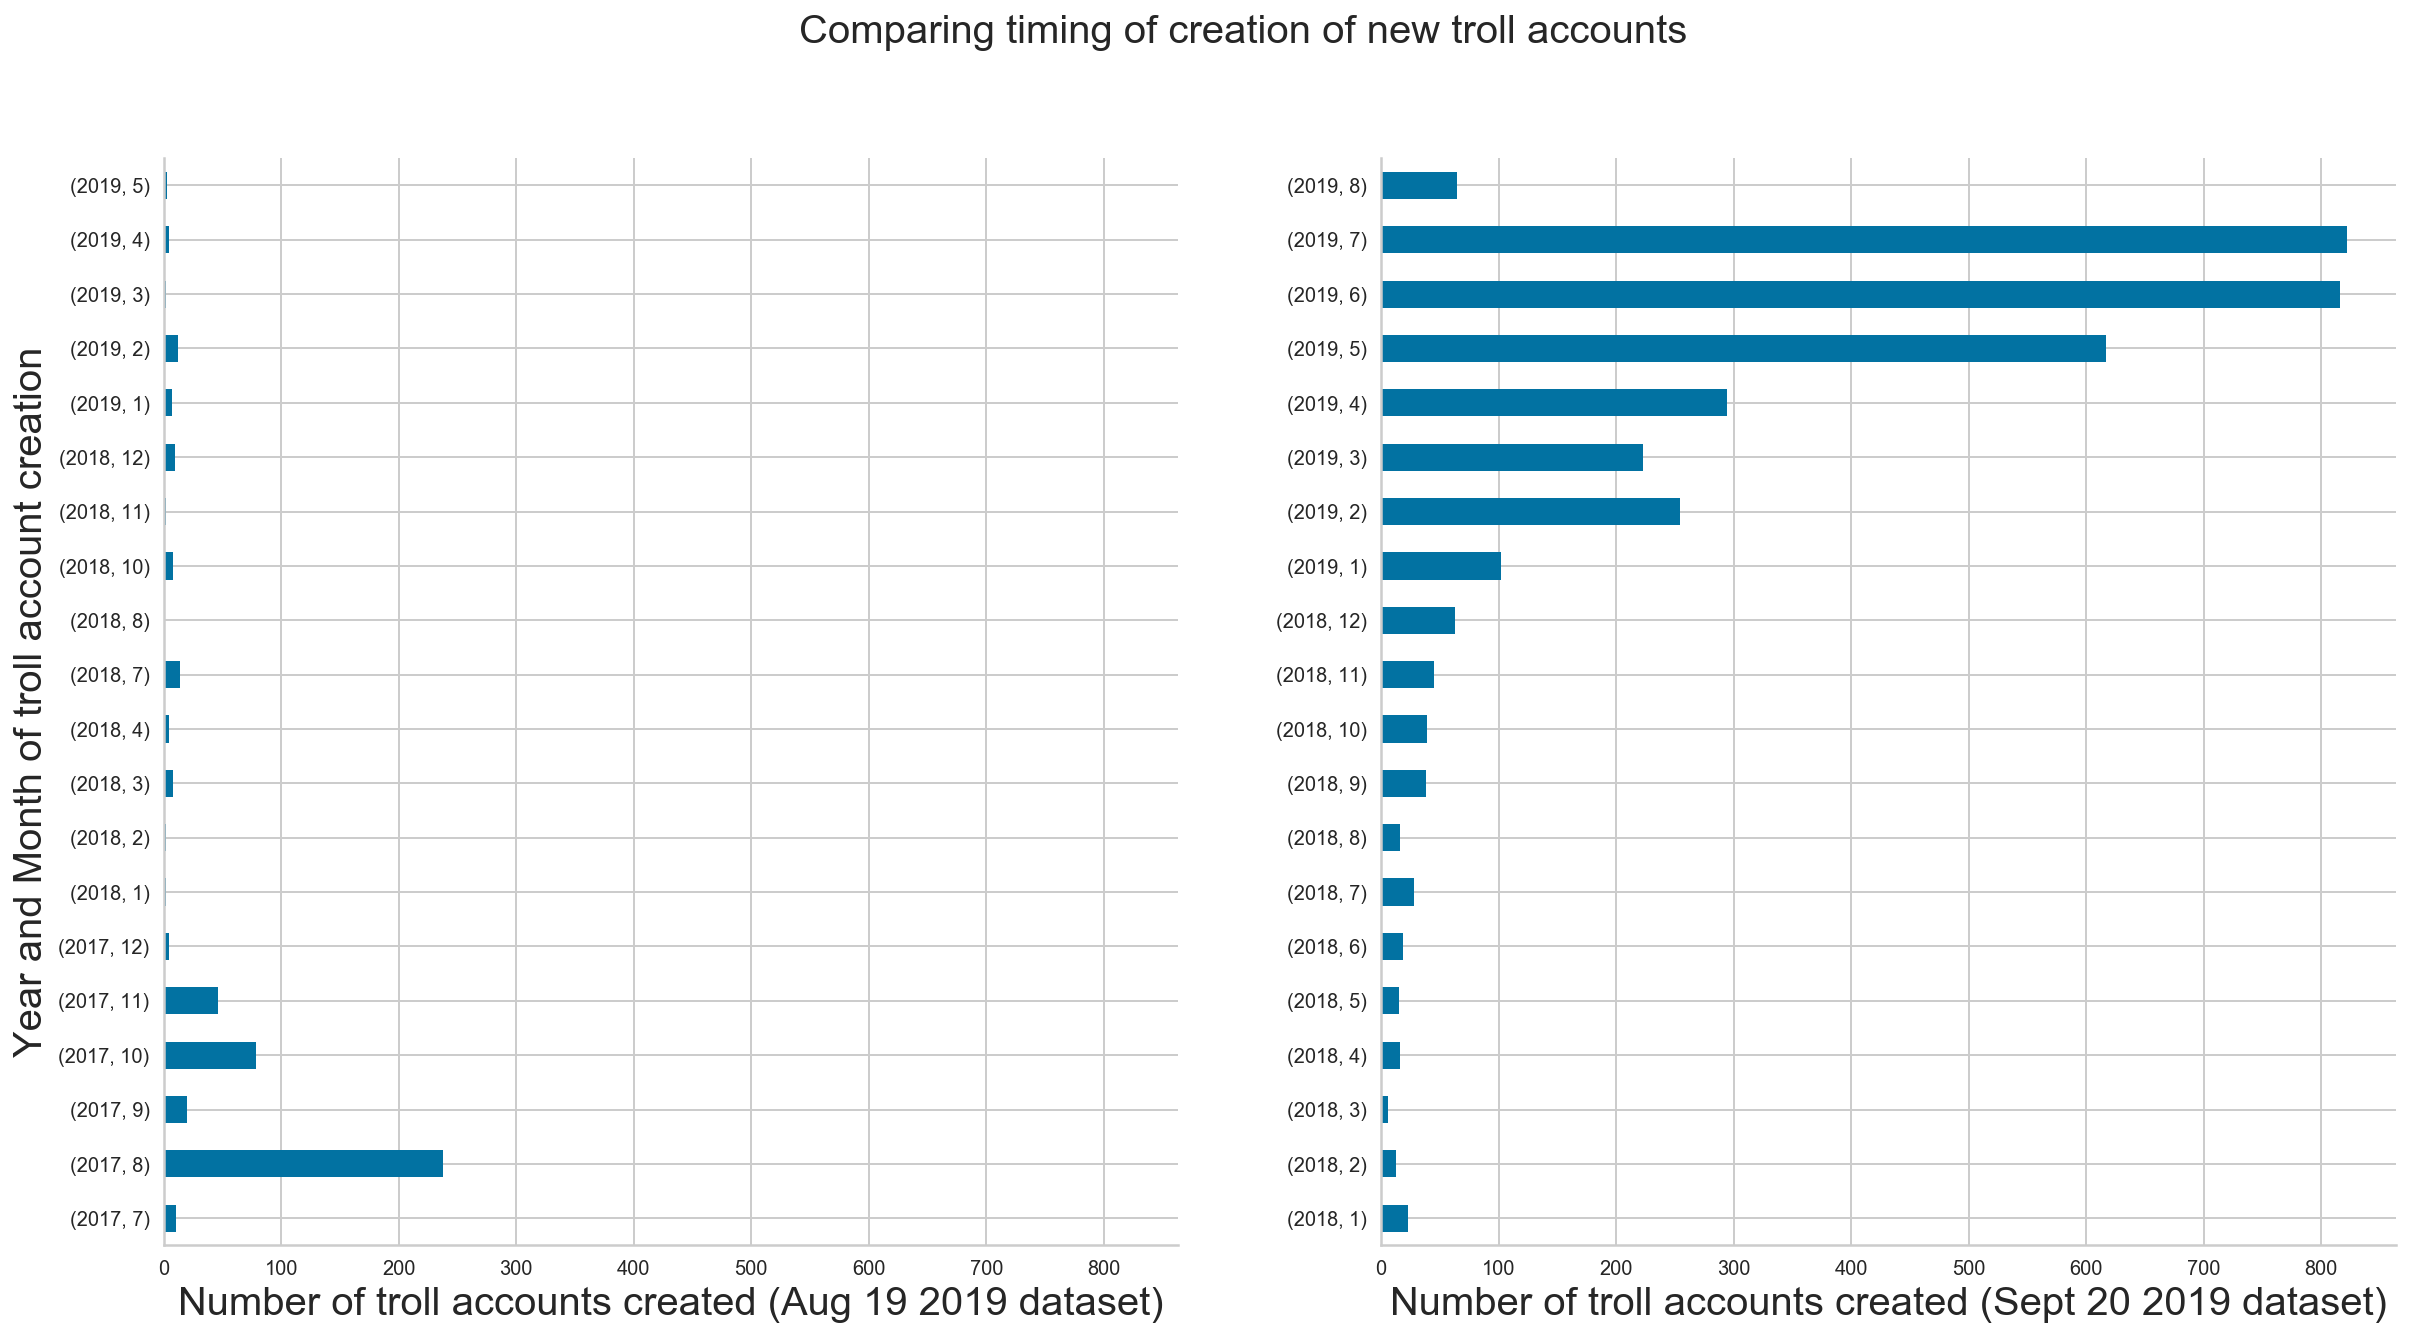

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

raw_aug.groupby(
    ["year_of_account_creation", "month_of_account_creation"]
).user_screen_name.nunique().sort_index(ascending=True).tail(20).plot(kind="barh", ax=axs[0])

raw_sept.groupby(
    ["year_of_account_creation", "month_of_account_creation"]
).user_screen_name.nunique().sort_index(ascending=True).tail(20).plot(kind="barh", ax=axs[1])

fig.suptitle(
    "Comparing timing of creation of new troll accounts",
    fontsize=20,
)
axs[0].set_ylabel("Year and Month of troll account creation", fontsize=20)
axs[0].set_xlabel("Number of troll accounts created (Aug 19 2019 dataset)", fontsize=20)
axs[1].set_xlabel("Number of troll accounts created (Sept 20 2019 dataset)", fontsize=20)
axs[1].set_ylabel("", fontsize=20)
sns.despine()
plt.show()

## 2.1.1 PLOTLY INTERACTIVE CHART
I'll make a Plotly version of the chart above for easier exploration of the data.

In [15]:
y1 = [
    "2018 Dec",
    "2018 Nov",
    "2018 Oct",
    "2018 Sept",
    "2018 Aug",
    "2018 July",
    "2018 Jun",
    "2018 May",
    "2018 April",
    "2018 Mar",
    "2018 Feb",
    "2018 Jan",
    "2017 Dec",
    "2017 Nov",
    "2017 Oct",
    "2017 Sept",
    "2017 Aug",
    "2017 July",
]

x1 = [10, 2, 8, 1, 14, 5, 8, 2, 2, 5, 46, 79, 20, 238, 11]

y2 = [
    "2019 Aug",
    "2019 Jul",
    "2019 Jun",
    "2019 May",
    "2019 Apr",
    "2019 Mar",
    "2019 Feb",
    "2019 Jan",
    "2018 Dec",
    "2018 Nov",
    "2018 Oct",
    "2018 Sept",
    "2018 Aug",
    "2018 July",
    "2018 Jun",
    "2018 May",
    "2018 April",
    "2018 Mar",
]

x2 = [
    65,
    822,
    816,
    617,
    294,
    223,
    254,
    102,
    63,
    45,
    39,
    38,
    16,
    28,
    19,
]


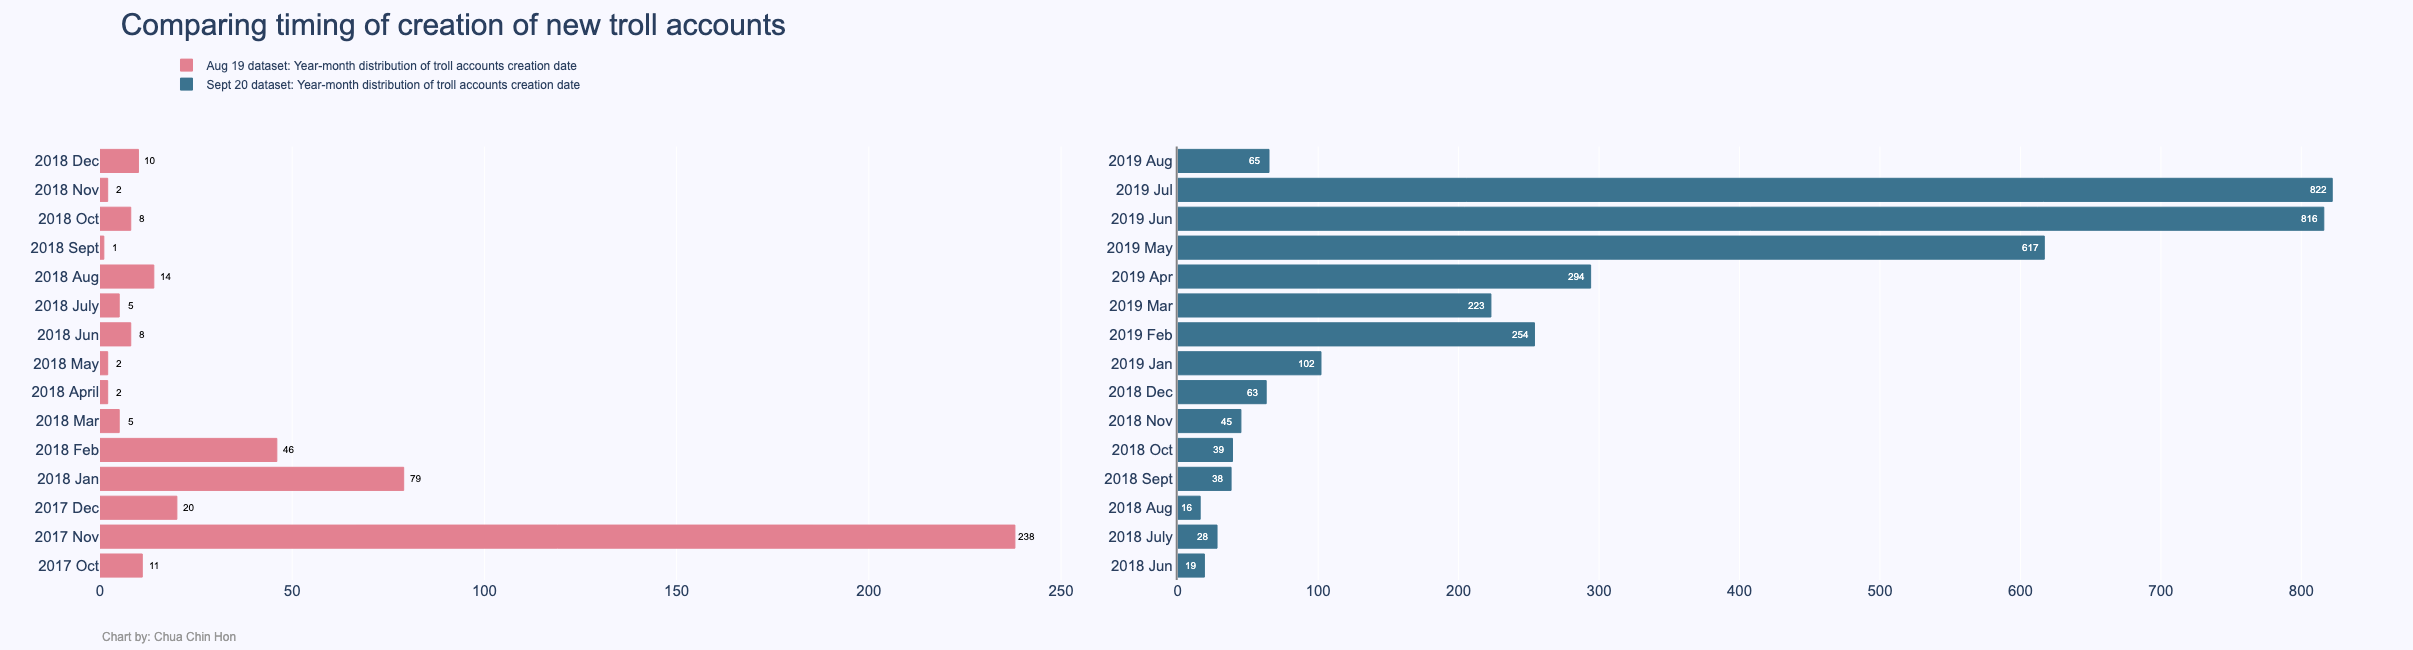

In [16]:
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.01)

fig.append_trace(go.Bar(
    x=x1,
    y=y1,
    marker=dict(
        color='rgb(227, 129, 145)',
        line=dict(
            color='rgb(227, 129, 145)',
            width=1),
    ),
    name='Aug 19 dataset: Year-month distribution of troll accounts creation date',
    orientation='h',
), 1, 1)

fig.append_trace(go.Bar(
    x=x2,
    y=y2,
    marker=dict(
        color='rgb(59,115,143)',
        line=dict(
            color='rgb(59,115,143)',
            width=1),
    ),
    name='Sept 20 dataset: Year-month distribution of troll accounts creation date',
    orientation='h',
), 1, 2)


fig.update_layout(
    title=go.layout.Title(
        text='Comparing timing of creation of new troll accounts',
        font=dict(family='Arial', size=30))

)


fig.update_layout(
    font=dict(family='Arial', size=15),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        autorange="reversed",
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=True,
        autorange="reversed",
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
    ),
    legend=dict(x=0.029, y=1.038, font_size=12),
    margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    height=650
)

annotations = []

#x_mth = np.round(x_month)
#x_dy = np.round(x_day)

for xd, yd in zip(x2, y2):
    annotations.append(dict(xref='x2', yref='y2',
                            y=yd, x=xd-10,
                            text=str(xd),
                            font=dict(family='Arial', size=10,
                                      color='rgb(255,255,255)'),
                            showarrow=False))
    
for xm, ym in zip(x1, y1):
    annotations.append(dict(xref='x1', yref='y1',
                            y=ym, x=xm+3,
                            text=str(xm),
                            font=dict(family='Arial', size=10,
                                      color='rgb(0,0,0)'),
                            showarrow=False))

# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0., y=-0.13,
                        text='Chart by: Chua Chin Hon',
                        font=dict(family='Arial', size=12, color='rgb(150,150,150)'),
                        showarrow=False))    
    

fig.update_layout(annotations=annotations)

fig.show()

# py.plot(fig, filename='../charts/accounts_creation.html')
# Download this chart from the "charts" folder in the repo

# 3. ANALYSIS OF "SURGE" ACCOUNTS
Due to time and resource constraints, I'll focus the subsequent analysis on the Chinese state troll accounts created between May and Aug 2019, which accounted for nearly 54% of the 4,301 accounts uncovered in the 2nd tranche of tweets released by Twitter.

But as we would see later, some of the top trolls were created much earlier.

A deeper dive into the entire 2nd tranche will have to be left to better resourced research institutes.

In [17]:
# I included August as the drop in account creation is likely due to action by Twitter, 
# rather than any intentional efforts by Beijing to stop creating new accounts

surge = raw_sept[
    (raw_sept["year_of_account_creation"]
    == 2019)
    & (
        (raw_sept["month_of_account_creation"]
        == 8) |
            (raw_sept["month_of_account_creation"]
        == 7) | (raw_sept["month_of_account_creation"]
        == 6) | (raw_sept["month_of_account_creation"]
        == 5)
    )
]

In [18]:
# The new troll accounts sent about 87k tweets and retweets during the "surge"
surge.shape

(87369, 19)

In [19]:
print("Unique user screen names:", surge["user_screen_name"].nunique())
print("Unique user reported locations:", surge["user_reported_location"].nunique())
print("Unique user creation dates:", surge["account_creation_date"].nunique())
print("Unique account languages:", surge["account_language"].nunique())
print("Unique tweet languages:", surge["tweet_language"].nunique())
print("Unique tweet text:", surge["tweet_text"].nunique())
print("Unique hashtags:", surge["hashtags"].nunique())


Unique user screen names: 2320
Unique user reported locations: 197
Unique user creation dates: 107
Unique account languages: 7
Unique tweet languages: 37
Unique tweet text: 27192
Unique hashtags: 1008


## NOTE: 
The number of "unique tweets" in this surge set is just 27,192, significantly lower than the total number of rows - 87,369. This suggests many of the accounts were retweeting each other, or more likely, tweets from the lead troll accounts.

## 3.1 USER REPORTED LOCATIONS IN SURGE SET
Unsurprisingly, many of the new troll accounts claimed to be from the US, or even Russia, which used this tactic in their 2016 campaign against the US Presidential election.

In [20]:
surge.groupby(["user_reported_location"]).user_screen_name.nunique().sort_values(
    ascending=False
).head(10)

user_reported_location
United States                 114
New York, USA                  28
Russia                         24
Canada                         24
Amsterdam, The Netherlands     23
Toronto, Ontario               12
Mississauga, Ontario            5
Florida, USA                    4
Hong Kong                       4
Markham, Ontario                4
Name: user_screen_name, dtype: int64

## 3.2 MATCHING KEY POLITICAL DATES WITH SURGE ACCOUNT CREATION

In [21]:
# Breaking down the surge troll accounts further by day of account creation
surge_accounts = surge.groupby(["month_of_account_creation", 'day_of_account_creation']).user_screen_name.nunique().sort_values(
    ascending=False)

surge_accounts = pd.DataFrame(
    surge_accounts.reset_index().rename(
        columns={"index": "Month",
                 0: "Day", 
                 1: "No of unique troll acounts created"}
    )
)
surge_accounts.columns = ["Month", "Day", "No of unique troll acounts created"]
surge_accounts.head(20)

Month  Day  No of unique troll acounts created
0       6   14                                  76
1       7    5                                  67
2       7    2                                  59
3       5    8                                  49
4       5   24                                  47
5       7    1                                  46
6       6   27                                  45
7       7   22                                  43
8       6   19                                  43
9       7    4                                  42
10      6   30                                  41
11      7   11                                  40
12      6   18                                  40
13      5   13                                  39
14      7   10                                  39
15      5   17                                  38
16      5   18                                  38
17      5    7                                  37
18      7   13                                  37
19      7   15                                  37

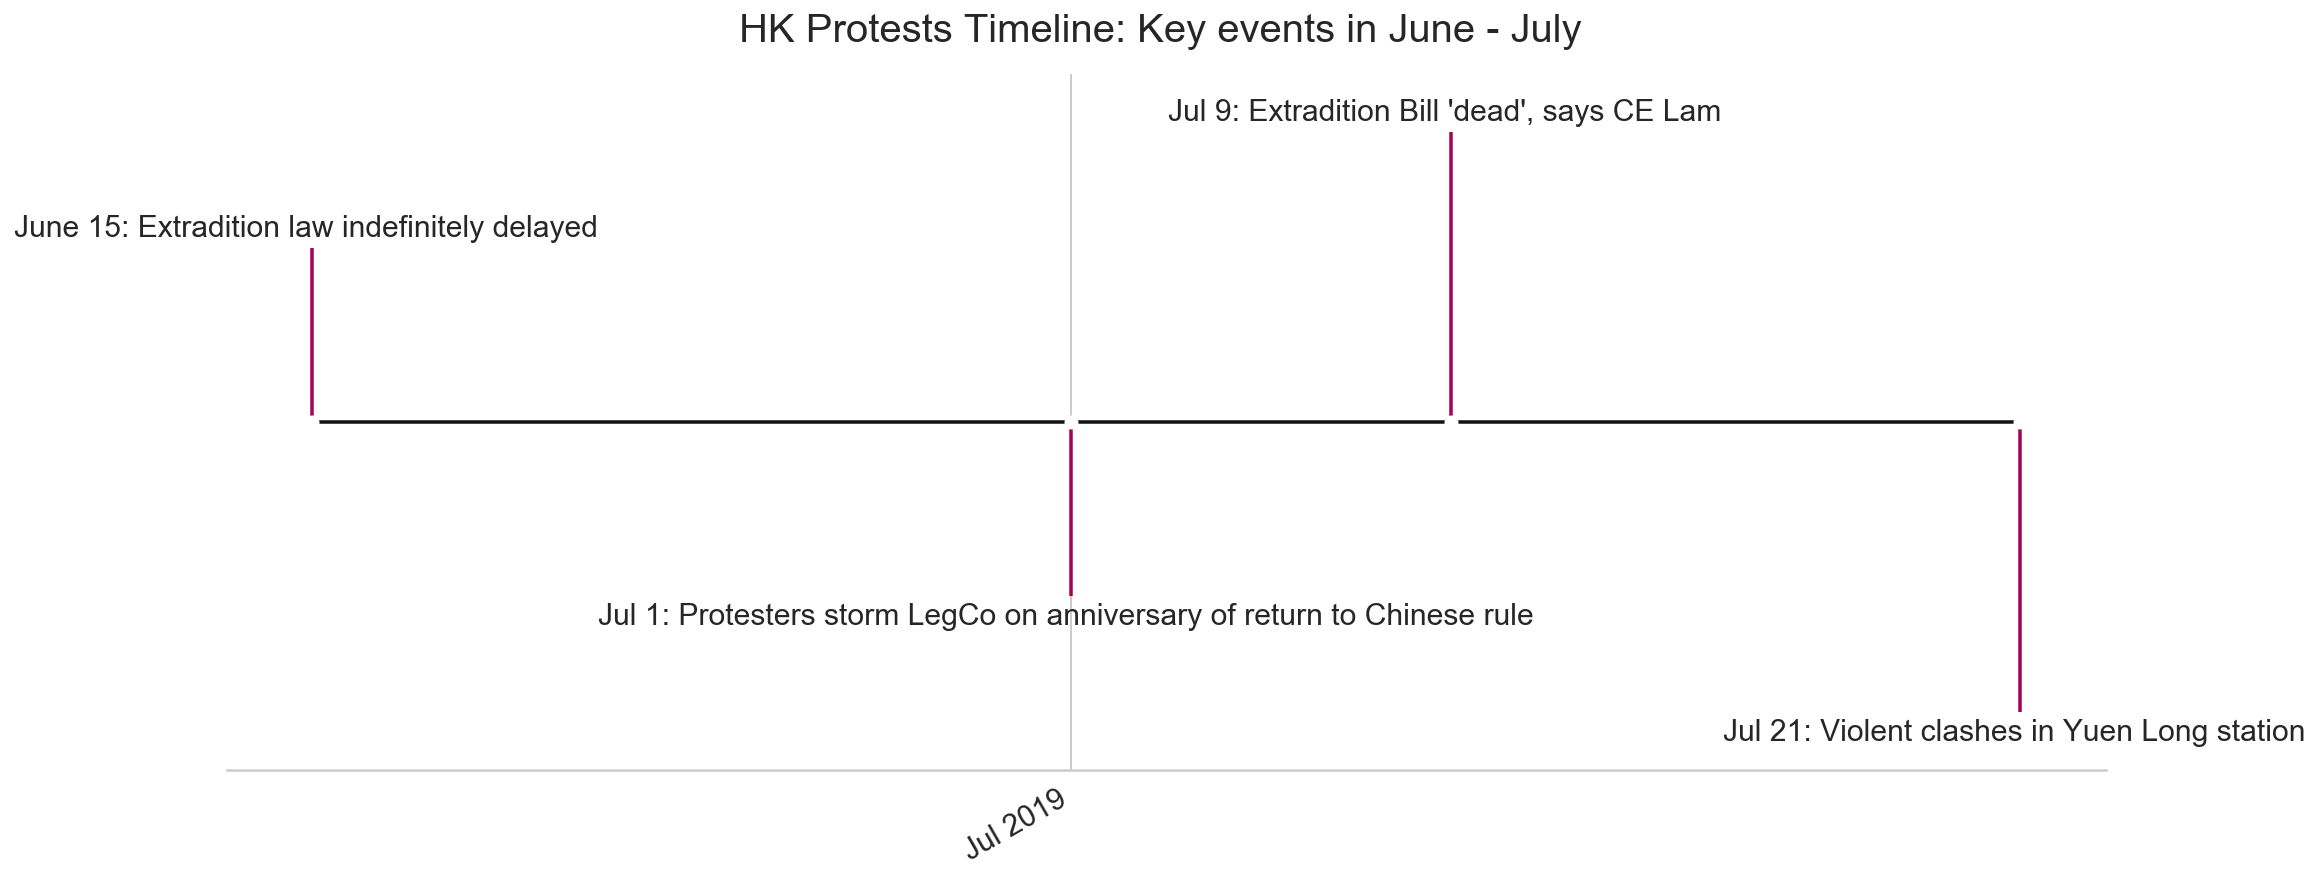

In [22]:
surge_dates = [
    "Jul 21: Violent clashes in Yuen Long station",
    "Jul 9: Extradition Bill 'dead', says CE Lam",
    "Jul 1: Protesters storm LegCo on anniversary of return to Chinese rule",
    "June 15: Extradition law indefinitely delayed",
]

dates = ["2019-07-21", "2019-07-09", "2019-07-01", "2019-06-15"]
top_dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

levels = np.tile([-5, 5, -3, 3, -1, 1], int(np.ceil(len(top_dates) / 6)))[
    : len(top_dates)
]

# Create figure and plot a stem plot with the dates
fig, ax = plt.subplots(figsize=(16, 6), constrained_layout=True)

fig.suptitle("HK Protests Timeline: Key events in June - July", fontsize=20)

markerline, stemline, baseline = ax.stem(
    top_dates, levels, linefmt="C3-", basefmt="k-", use_line_collection=True
)

plt.setp(markerline, mec="k", mfc="w", zorder=3)

markerline.set_ydata(np.zeros(len(top_dates)))

# annotate lines
vert = np.array(["top", "bottom"])[(levels > 0).astype(int)]
for d, l, r, va in zip(top_dates, levels, surge_dates, vert):
    ax.annotate(
        r,
        xy=(d, l),
        xytext=(-3, np.sign(l) * 3),
        textcoords="offset points",
        va=va,
        ha="center",
        fontsize=15,
    )

# format xaxis
ax.get_xaxis().set_major_locator(mdates.MonthLocator())
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize=15)

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()


## NOTE:
No surprises here: The days which have seen the highest number of new troll account creation fell on, or were near key dates in Hong Kong which saw major political announcements, or violent clashes in parts of the city.

The largest spike in troll account creation in one day was on June 14 - one day before [HK chief executive Carrie Lam suspended the extradition bill which sparked the protests](https://www.scmp.com/news/hong-kong/politics/article/3014669/hong-kong-leader-carrie-lam-backs-down-over-extradition). Coincidence or coordination? No way to tell, but the timing is notable.

There were also noticeable spikes in troll account creation on and a day before July 1 2019, the 22nd anniversary of Hong Kong's return to Chinese rule. The anniversary was marked by massive protests and a storming of the Legislative Council building by some protestors.

Here's a fuller [timeline of events](https://www.reuters.com/article/us-hongkong-protests-timeline/timeline-key-dates-in-hong-kongs-protests-idUSKCN1VP0OR).

## 3.3 LANGUAGE SETTING, TWEET LANGUAGE USED
The broader set of tweets in both tranches are full of irrelevant content on sports, porn, global politics etc, and in multiple languages, such as Bahasa Indonesia.

But the Chinese agency behind the disinformation campaign appeared to be more focused during the "surge" phase, creating accounts that were predominantly set to English and Chinese. These new troll accounts also tweeted primarily in Chinese and English, as the breakdown below shows:

In [23]:
surge_account_language = surge.groupby(["account_language"]).user_screen_name.nunique().sort_values(
    ascending=False)

surge_account_language = pd.DataFrame(
    surge_account_language.reset_index().rename(
        columns={"index": "Account language setting",
                 0: "No of unique troll acounts"}
    )
)
surge_account_language.columns = ["Acount language setting", "No of unique troll acounts"]
surge_account_language

Acount language setting  No of unique troll acounts
0                      en                        1911
1                   zh-cn                         366
2                   zh-tw                          28
3                      tr                          10
4                   zh-CN                           3
5                      ru                           1
6                      ja                           1

In [24]:
surge_tweet_language = surge.groupby(["tweet_language"]).user_screen_name.nunique().sort_values(
    ascending=False
)

surge_tweet_language = pd.DataFrame(
    surge_tweet_language.reset_index().rename(
        columns={"index": "Tweet language",
                 0: "No of unique troll acounts"}
    )
)
surge_tweet_language.columns = [" Tweet language", "No of unique troll acounts"]
surge_tweet_language.head(10)

Tweet language  No of unique troll acounts
0              zh                        2315
1              en                        1115
2              ja                         923
3             und                         660
4              ru                          70
5              in                          28
6              pt                          27
7              es                          27
8              no                          22
9              tr                          19

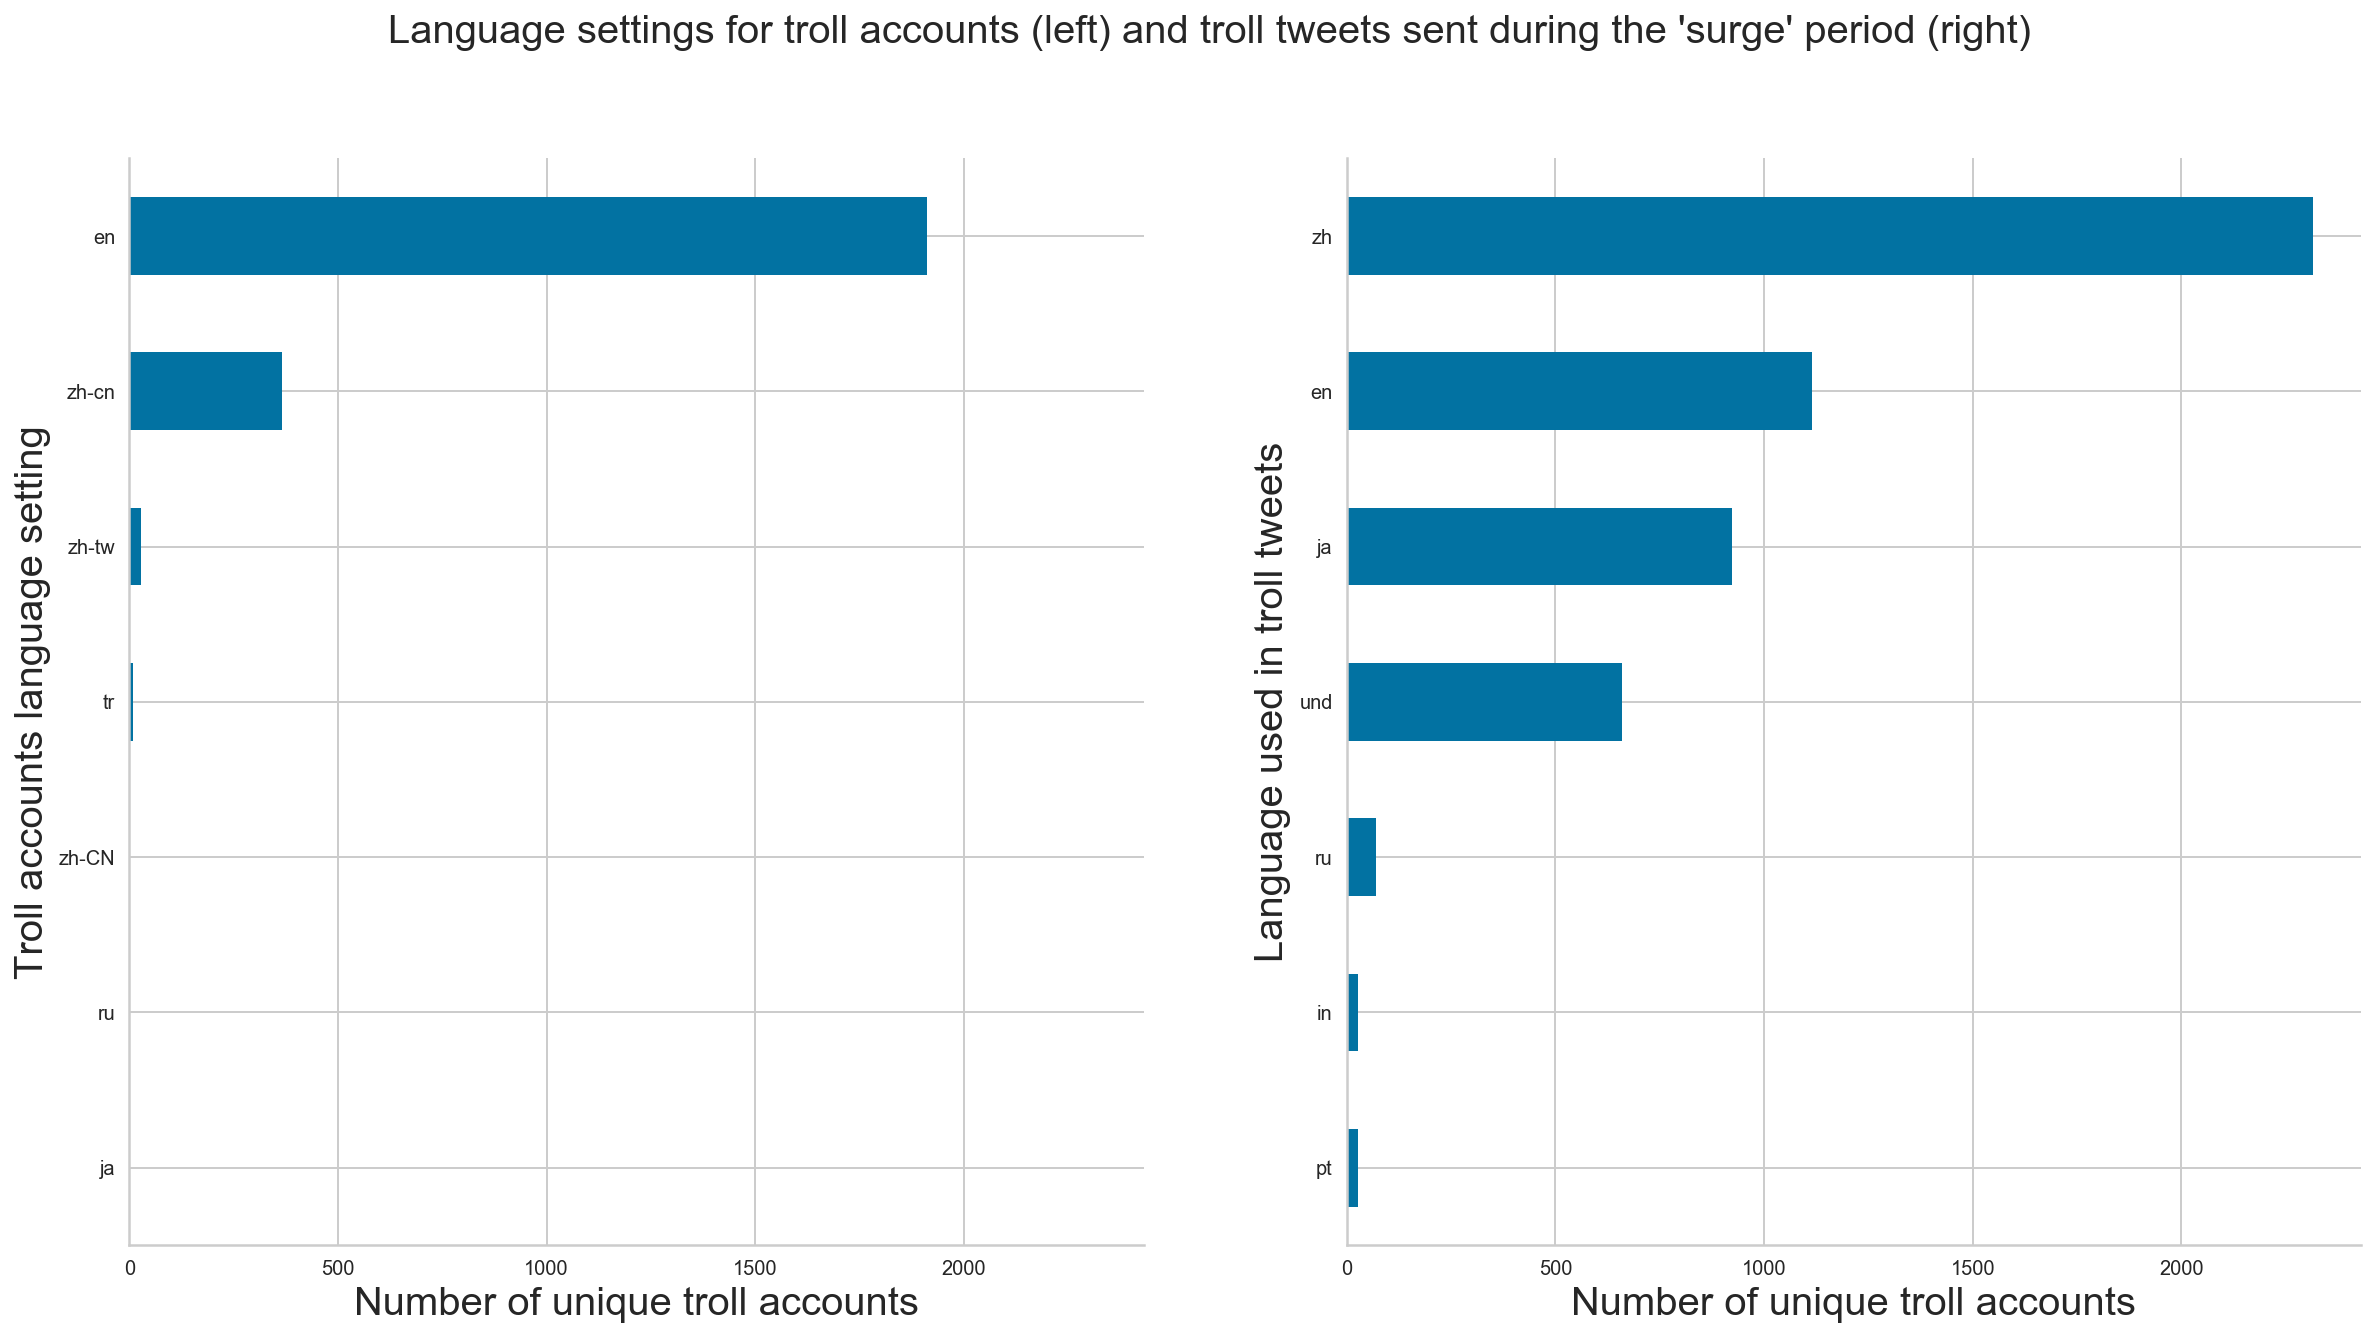

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

surge.groupby(["account_language"]).user_screen_name.nunique().sort_values(
    ascending=True
).plot(kind="barh", ax=axs[0])

surge.groupby(["tweet_language"]).user_screen_name.nunique().sort_values(
    ascending=True
).tail(7).plot(kind="barh", ax=axs[1])

fig.suptitle(
    "Language settings for troll accounts (left) and troll tweets sent during the 'surge' period (right)",
    fontsize=20,
)
axs[0].set_ylabel("Troll accounts language setting", fontsize=20)
axs[0].set_xlabel("Number of unique troll accounts", fontsize=20)
axs[1].set_xlabel("Number of unique troll accounts", fontsize=20)
axs[1].set_ylabel("Language used in troll tweets", fontsize=20)
sns.despine()
plt.show()


## 3.4 TWEET ACTIVITY
As expected, the troll accounts created during this "surge" period were tweeting/retweeting most frequently in July, when the protests and clashes on the streets escalated beyond a level hitherto unseen. Let's break it down in greater detail.  

In [26]:
# July saw the highest number of unique troll accounts actively tweeting/retweeting on a given day. 
tweet_frequency = surge.groupby(["tweet_month", "tweet_day"]).user_screen_name.nunique().sort_values(
    ascending=False)

tweet_frequency = pd.DataFrame(
    tweet_frequency.reset_index().rename(
        columns={"index": "Month",
                 1: "Day",
                 0: "No of unique troll acounts tweeting that day"}
    )
)
tweet_frequency.columns = ["Month", "Day", "No of unique troll acounts tweeting that day"]
tweet_frequency.head(20)

Month  Day  No of unique troll acounts tweeting that day
0       7    9                                           420
1       7   17                                           418
2       7   16                                           414
3       7   11                                           409
4       7   12                                           406
5       7   19                                           405
6       7   25                                           404
7       7   23                                           400
8       7    8                                           399
9       7   22                                           398
10      7   24                                           385
11      7   10                                           377
12      7   15                                           367
13      7   18                                           367
14      7    5                                           361
15      7   26                                           291
16      7   30                                           276
17      7    1                                           266
18      7   29                                           247
19      7    4                                           244

### Worth noting what happened on July 9, when the number of "surge" troll accounts tweeting/retweeting away was at its peak: HK CE Carrie Lam announced that the extradition bill was dead and that her government's work on the legislation had been a “total failure”.

In [27]:
surge_tweets = surge.groupby(["tweet_time", "tweet_month", "tweet_day"]).user_screen_name.nunique().sort_values(
    ascending=False)


surge_tweets = pd.DataFrame(
    surge_tweets.reset_index().rename(
        columns={"index": "Date",
                 0: "Month", 
                 1: "Day", 
                 2: "No of troll tweets/retweets"}
    )
)
surge_tweets.columns = ["Date", "Month", "Day", "No of troll tweets/retweets"]
surge_tweets.head()

Date  Month  Day  No of troll tweets/retweets
0 2019-07-24 14:39:00+08:00      7   24                           24
1 2019-07-17 10:31:00+08:00      7   17                           24
2 2019-07-17 10:44:00+08:00      7   17                           22
3 2019-06-21 10:43:00+08:00      6   21                           22
4 2019-07-12 14:24:00+08:00      7   12                           21

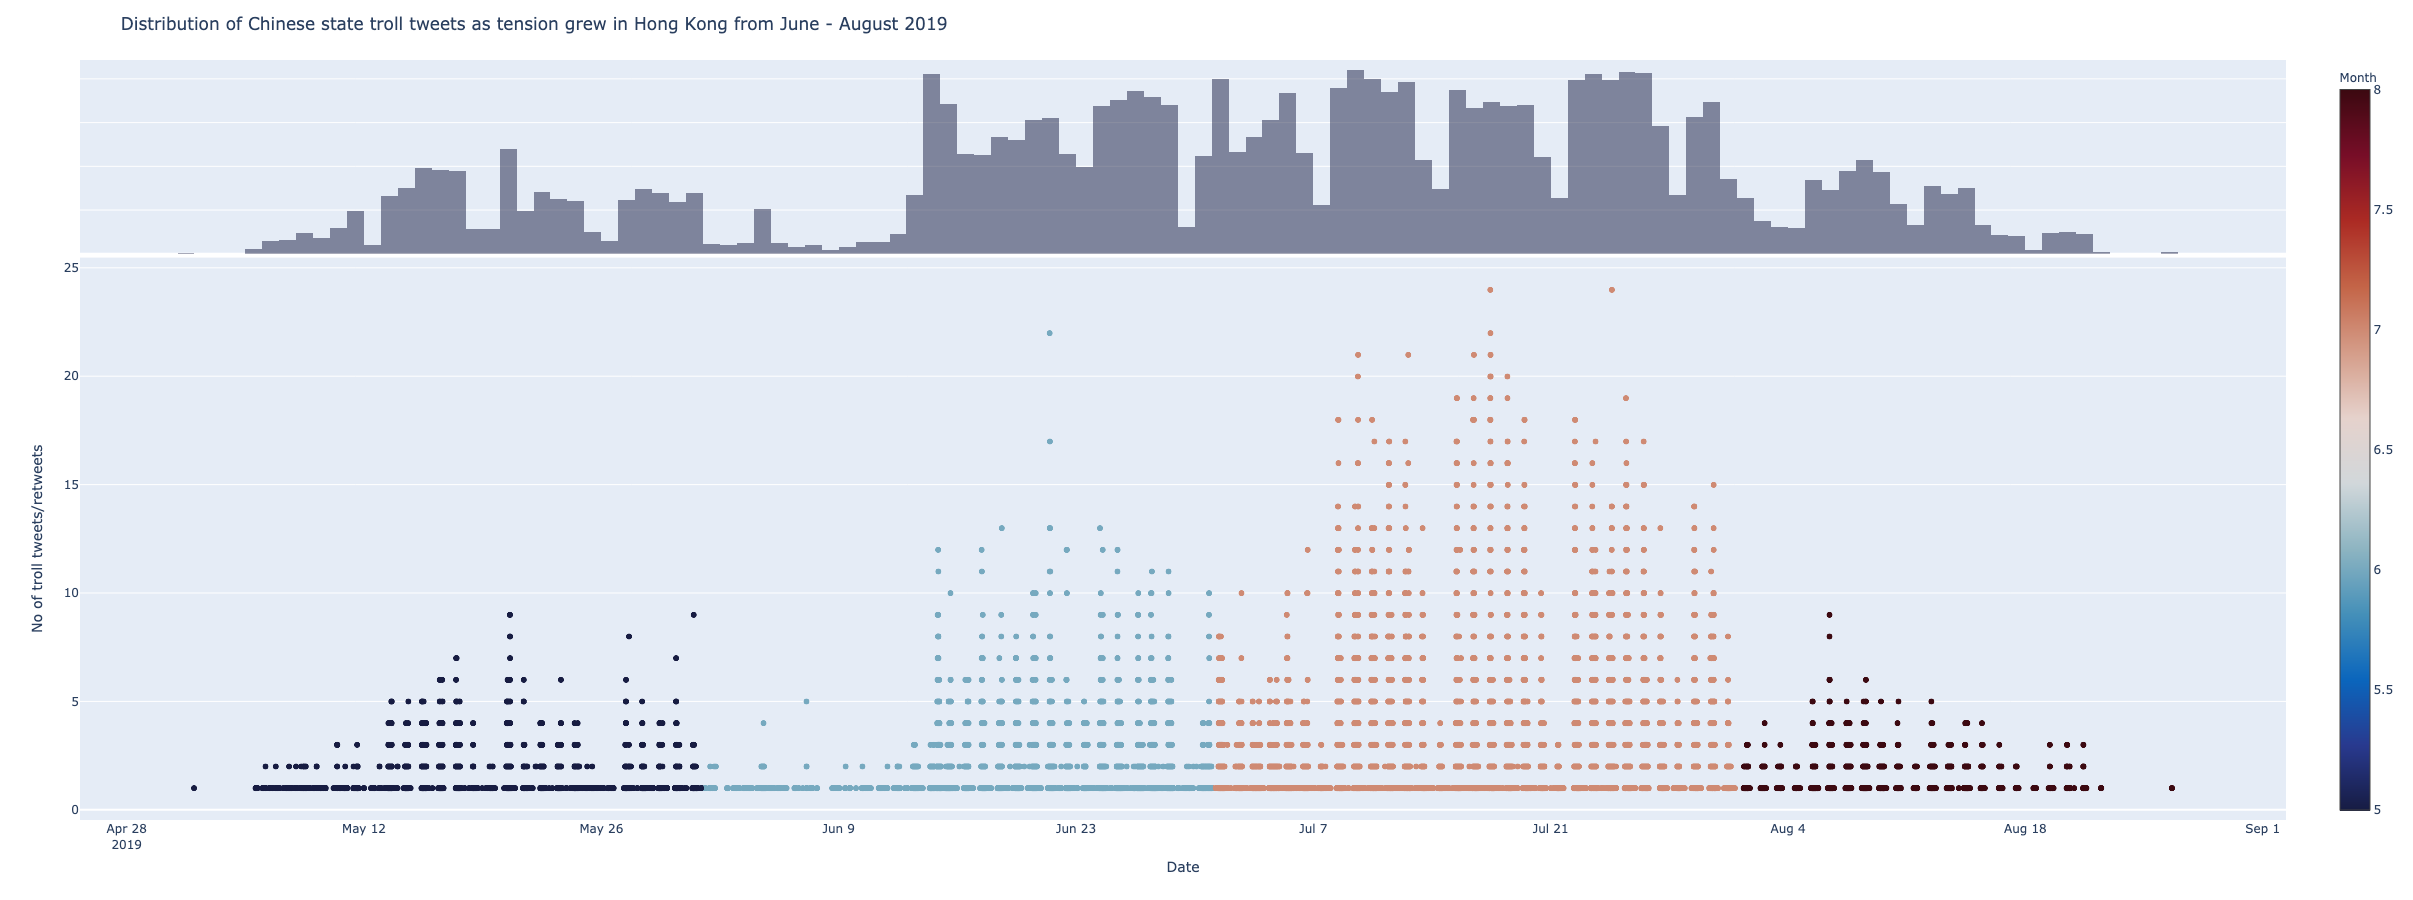

In [28]:
fig = px.scatter(
    surge_tweets, 
    x="Date", 
    y="No of troll tweets/retweets", 
    color="Month",
    color_continuous_scale=px.colors.diverging.balance,
    marginal_x="histogram")

fig.update_layout(
    title=go.layout.Title(
        text="Distribution of Chinese state troll tweets as tension grew in Hong Kong from June - August 2019"
    ),       
    autosize=False,
    width=2200,
    height=900,
)

fig.show()
# py.plot(fig, filename='../charts/surge_tweets.html')
# Download this chart in the repo's "charts" folder

### Hover over the specific data points to see the detailed timings for when the troll tweets peaked.

# 4. SURGE TWEETS

One dominant thread in the first tranche of Chinese troll tweets released by Twitter was the conspiracy theory that the US is the “black hand” behind the protests in Hong Kong. Let's see whether this is still the case in the second tranche, or if a new focus had emerged.

We also know from analysing the earlier tranche that some considerable filtering have to be done, for tweets irrelevant to the HK protests, such as a running war of words with fugitive Chinese billionaire Guo Wengui. See my [earlier Medium post for details](https://towardsdatascience.com/hkprotest-visualizing-state-troll-tweets-from-chinas-disinformation-campaign-1dc4bcab437d). I'll be applying the same filtering logic as those in the [notebook2.0 series](https://github.com/chuachinhon/twitter_hk_trolls_cch/tree/master/notebooks).

In [29]:
# Prior to filtering, this subset had 87k rows
surge.shape

(87369, 19)

In [30]:
surge['tweet_text'].sample(10)

2083779    RT @Eysha1008: #逃犯条例   逃犯条例中”让在大陆、台 湾、澳门犯了杀人、强...
1541146    RT @feituji1994: Believe in our dream！！ https:...
457971           @Edxdazfa 暴徒的行為違背憲法，損害香港的根本及長遠利益，也損害國家民族尊嚴。
159063                   @frassicachar 是谁在破坏香港的未来，是谁在保卫香港的和平
2205648    RT @feituji1994: 屡次挑衅元朗人，还要挖人家祖坟，是佛也有三分火！元朗人团结...
1163702    RT @feituji1994: #HongKong #HK #antiELAB #香港 #...
2097358    RT @n11cky: 郭文贵，一个被国际刑警组织追缉的中国逃犯，在中国涉嫌诈骗、强奸、洗钱...
728688     RT @feituji1994: 屡次挑衅元朗人，还要挖人家祖坟，是佛也有三分火！元朗人团结...
1978834    RT @gendmasthus: 官媒斥反對派勾結外部勢力 煽惑民眾騷亂拖垮香港\n本港金鍾...
481542                   @Huiava6 郭文贵 “匠心独运”的语言艺术也真实写照他悲惨的人生
Name: tweet_text, dtype: object

In [31]:
# In 2.0 series of the notebooks, I similarly filtered out these keywords which contributed to a lot of noise in the analysis
surge = surge[~surge["tweet_text"].str.contains("郭文贵")].copy()
surge = surge[~surge["tweet_text"].str.contains("文贵")].copy()
surge = surge[~surge["tweet_text"].str.contains("郭文")].copy()
surge = surge[~surge["tweet_text"].str.contains("Guo Wengui")].copy()
surge = surge[~surge["tweet_text"].str.contains("Wengui")].copy()
surge = surge[~surge["tweet_text"].str.contains("Guo")].copy()
surge = surge[~surge["tweet_text"].str.contains("杨建利")].copy()
surge = surge[~surge["tweet_text"].str.contains("郭宝胜")].copy()
surge = surge[~surge["tweet_text"].str.contains("宝胜")].copy()
surge = surge[~surge["tweet_text"].str.contains("老郭")].copy()
surge = surge[~surge["tweet_text"].str.contains("郭狗")].copy()
surge = surge[~surge["tweet_text"].str.contains("郭骗子")].copy()
surge = surge[~surge["tweet_text"].str.contains("余文生")].copy()
surge = surge[~surge["tweet_text"].str.contains("吴小晖")].copy()

In [32]:
# After filtering for just these news, the subset was down to 69K tweets, a near 18K reduction
surge.shape

(69402, 19)

## 4.1 SPLITTING SURGE TWEETS BY LANGUAGE
Next, I'll split the "surge tweets" into 2 subsets, 1 for English and 1 in Chinese. Accounts set to Chinese were also tweeting in English, and vice versa, hence this particular set of filtering conditions below.

In [33]:
surge_eng = surge[
    (surge["tweet_language"] == "en")
    & (
        (surge["account_language"] == "en")
        | (surge["account_language"] == "en-gb")
        | (surge["account_language"] == "zh-cn")
        | (surge["account_language"] == "zh-CN")
        | (surge["account_language"] == "zh-tw")
    )
].copy()


surge_ch = surge[
    (surge["tweet_language"] == "zh")
    & (
        (surge["account_language"] == "en")
        | (surge["account_language"] == "en-gb")
        | (surge["account_language"] == "zh-cn")
        | (surge["account_language"] == "zh-CN")
        | (surge["account_language"] == "zh-tw")
    )
].copy()

In [34]:
# Far higher number of tweets/retweets in Chinese than English 
surge_eng.shape, surge_ch.shape

((3723, 19), (59995, 19))

## NOTE:
As the breakdown above shows, Beijing's "tweet surge" was largely a Chinese language affair. English language troll tweets made up just 6%, or 3,723 tweets out of my filtered set of 69,402 tweets. 

Let's visualise the distribution of the English troll tweets against the Chinese ones.

In [35]:
surge_tweets_eng = surge_eng.groupby(["tweet_time", "tweet_month", "tweet_day"]).user_screen_name.nunique().sort_values(
    ascending=False)


surge_tweets_eng = pd.DataFrame(
    surge_tweets_eng.reset_index().rename(
        columns={"index": "Date",
                 0: "Month", 
                 1: "Day", 
                 2: "No of troll tweets/retweets"}
    )
)
surge_tweets_eng.columns = ["Date", "Month", "Day", "No of troll tweets/retweets"]
surge_tweets_eng.head()

Date  Month  Day  No of troll tweets/retweets
0 2019-07-02 18:15:00+08:00      7    2                            9
1 2019-07-05 11:25:00+08:00      7    5                            6
2 2019-07-05 11:26:00+08:00      7    5                            6
3 2019-07-02 18:06:00+08:00      7    2                            6
4 2019-06-17 09:53:00+08:00      6   17                            5

In [36]:
surge_tweets_ch = surge_ch.groupby(["tweet_time", "tweet_month", "tweet_day"]).user_screen_name.nunique().sort_values(
    ascending=False)


surge_tweets_ch = pd.DataFrame(
    surge_tweets_ch.reset_index().rename(
        columns={"index": "Date",
                 0: "Month", 
                 1: "Day", 
                 2: "No of troll tweets/retweets"}
    )
)
surge_tweets_ch.columns = ["Date", "Month", "Day", "No of troll tweets/retweets"]
surge_tweets_ch.head()

Date  Month  Day  No of troll tweets/retweets
0 2019-07-17 10:44:00+08:00      7   17                           21
1 2019-07-09 15:01:00+08:00      7    9                           20
2 2019-06-21 10:43:00+08:00      6   21                           19
3 2019-07-25 10:33:00+08:00      7   25                           19
4 2019-07-16 10:14:00+08:00      7   16                           18

In [37]:
# Setting a new "Language" column to differentiate the two dataframes after concatenation
surge_tweets_eng['Language'] = "English tweets/retweets"
surge_tweets_ch['Language'] = "Chinese tweets/retweets"

In [38]:
surge_tweets_count = pd.concat([surge_tweets_eng, surge_tweets_ch], sort=True)

In [39]:
surge_tweets_count.head()

Date  Day                 Language  Month  \
0 2019-07-02 18:15:00+08:00    2  English tweets/retweets      7   
1 2019-07-05 11:25:00+08:00    5  English tweets/retweets      7   
2 2019-07-05 11:26:00+08:00    5  English tweets/retweets      7   
3 2019-07-02 18:06:00+08:00    2  English tweets/retweets      7   
4 2019-06-17 09:53:00+08:00   17  English tweets/retweets      6   

   No of troll tweets/retweets  
0                            9  
1                            6  
2                            6  
3                            6  
4                            5

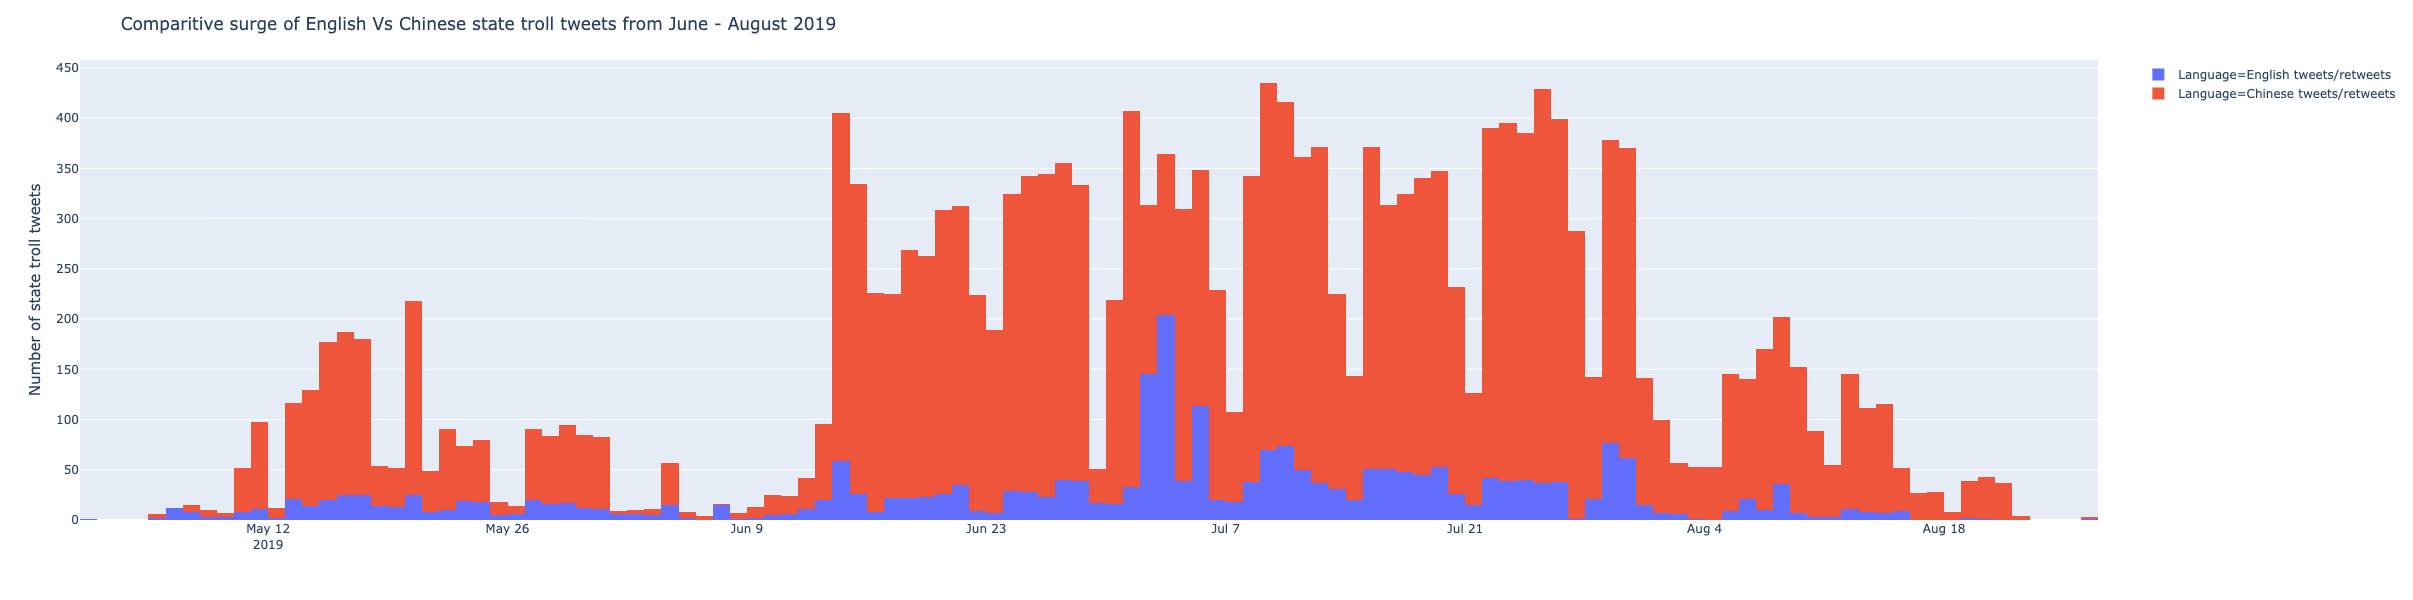

In [40]:
fig = px.histogram(
    surge_tweets_count, x="Date", y="No of troll tweets/retweets", color="Language"
)

fig.update_layout(
    title=go.layout.Title(
        text="Comparitive surge of English Vs Chinese state troll tweets from June - August 2019"
    )
)

fig.update_xaxes(title_text="", title_font=dict(size=15))
fig.update_yaxes(title_text="Number of state troll tweets", title_font=dict(size=15))

fig.show()

# py.plot(fig, filename="../charts/eng_versus_ch_tweets.html")
# Download this chart in the repo's "charts" folder


### The difference in the volume of English Vs Chinese troll tweets during this surge period is stark. Did someone in the disinformation campaign decide that they had already lost the battle for the hearts and minds of those who read in English?

## 4.2 KEY TERMS IN *ENGLISH TWEETS* TEXT
In my drafts for this analysis, it was clear that many accounts were used merely to retweet the material by the lead trolls. So it makes sense to further split the tweets subset down in terms of retweets and non-retweets. 

In the English subset, for instance, retweets made up more than half, or about 54%, of the set of tweets. Only 1,721 English tweets were "original", so to speak. 

In [41]:
#Splitting the English tweets during the surge phase into 2 - "original" tweets Vs retweets
surge_eng_no_rt = surge_eng[~surge_eng["tweet_text"].str.startswith("RT")].copy()

surge_eng_rt = surge_eng[surge_eng["tweet_text"].str.startswith("RT")].copy()

In [42]:
# As expected, retweets took up most of the English troll tweets, comprising 54% of the subset
surge_eng_no_rt. shape, surge_eng_rt.shape

((1721, 19), (2002, 19))

In [43]:
# function to clean tweet text
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"W", " ", text)
    text = text.strip(" ")
    text = text.strip(r"\n")
    text = re.sub(r"[^\w\s]", "", text)
    return text

In [44]:
surge_eng_no_rt['clean_tweet_text'] = surge_eng_no_rt['tweet_text'].map(lambda tweet: clean_tweet(tweet))

surge_eng_rt['clean_tweet_text'] = surge_eng_rt['tweet_text'].map(lambda tweet: clean_tweet(tweet))

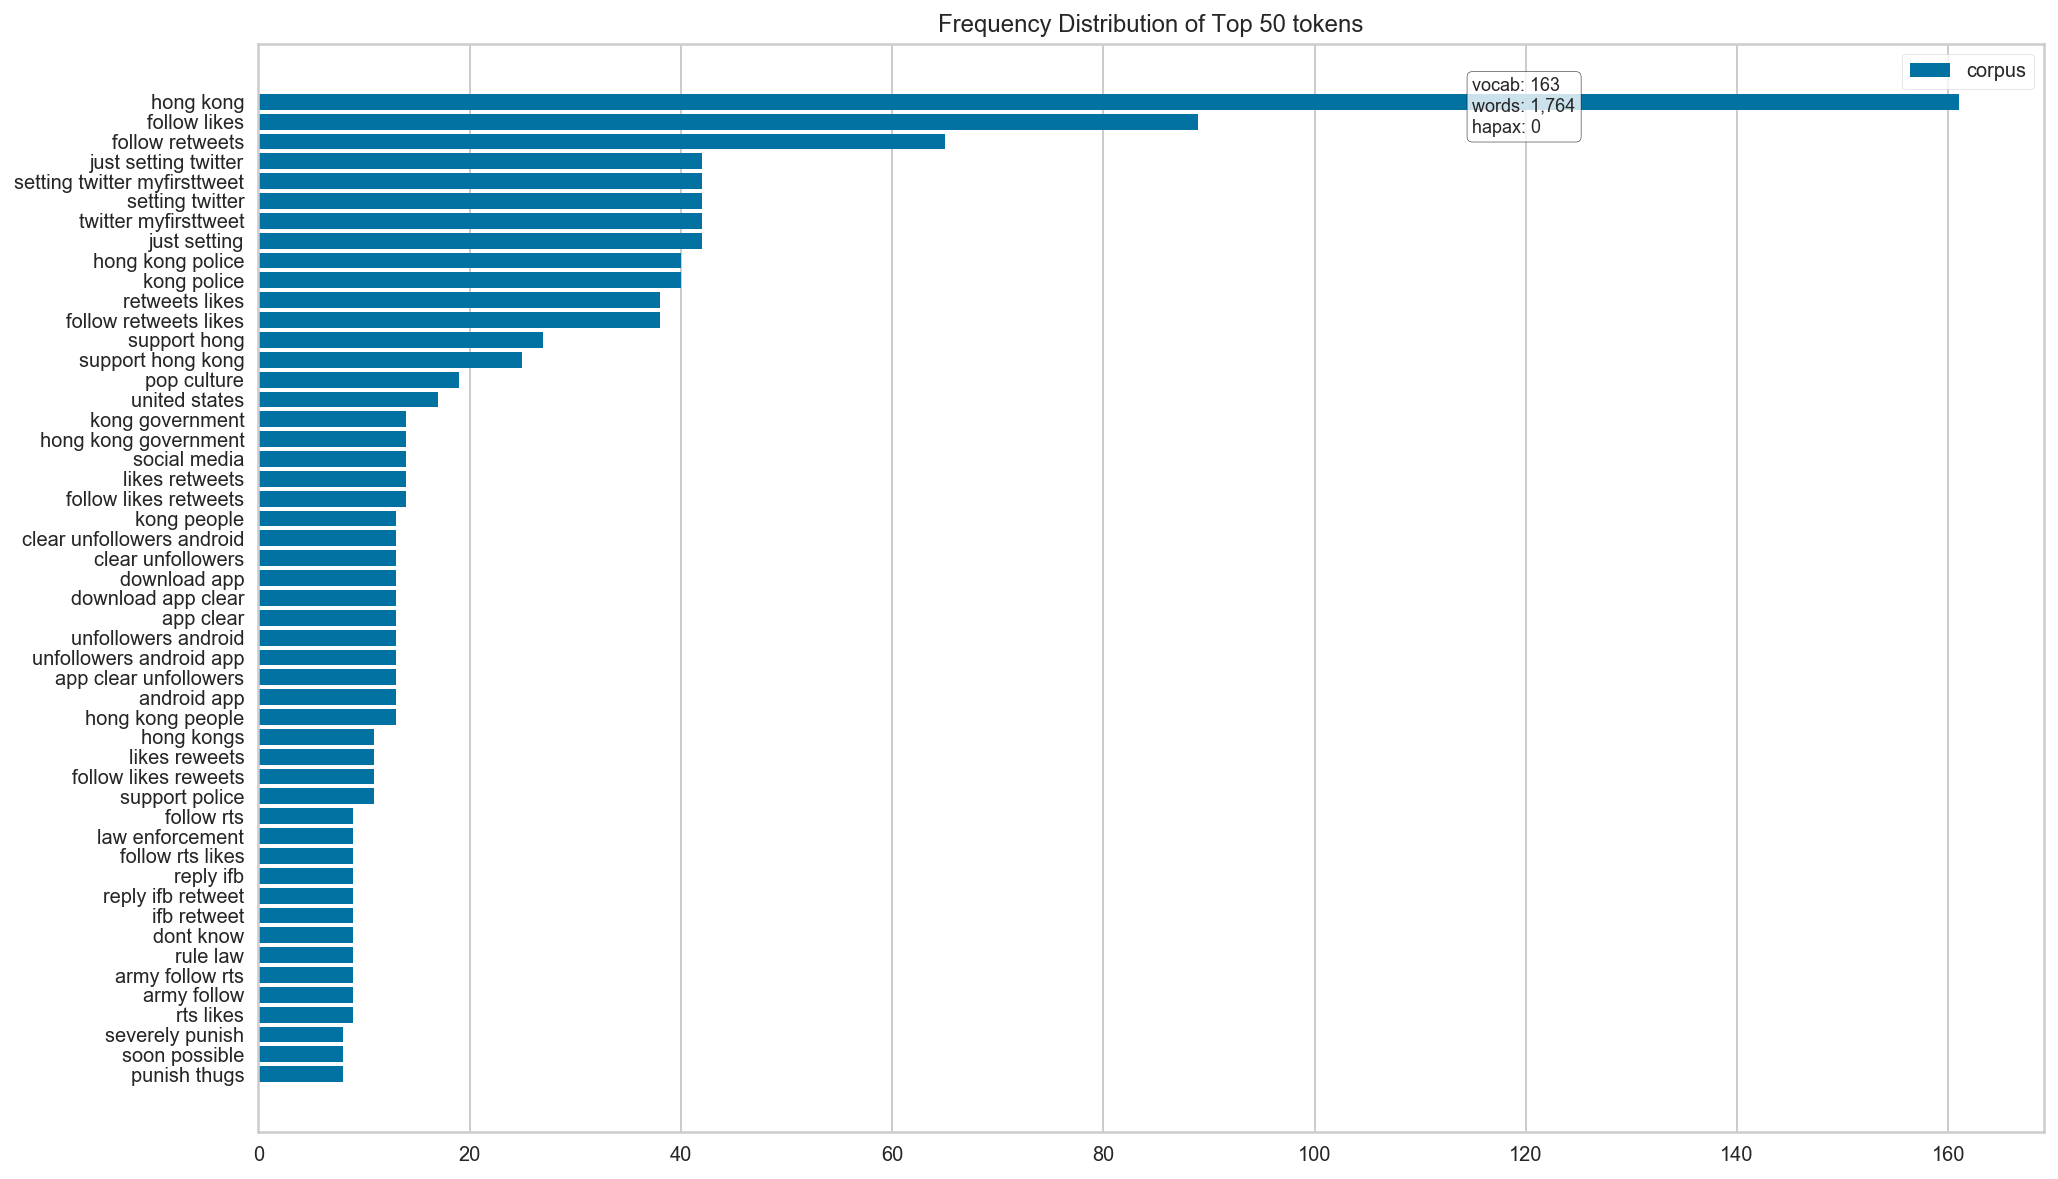

In [45]:
vect = CountVectorizer(
    tokenizer=lambda x: x.split(), stop_words="english", min_df=5, ngram_range=(2, 3)
)
docs = vect.fit_transform(surge_eng_no_rt["clean_tweet_text"].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

## NOTE:
Some of the most frequently used English words and phrases in this set are predictable, like "support hong kong" and "support police". But the key words that really caught my attention were "just setting twitter" and "myfirsttweet". Let's dig into that and find out what that's about.

In [46]:
noobs = surge_eng_no_rt[surge_eng_no_rt['clean_tweet_text'].str.contains('myfirsttweet')]

In [47]:
noobs['user_screen_name'].nunique()

43

In [48]:
noobs['user_screen_name'].unique()

array(['YuAz3l8sU2izEg7D7mcdPoXc2Vavji5CrbPuDsg8s08=',
       '7WXcPnsEv9ZdwHvibGWdcIn8ebsYqS+jtQ9RxWEBo+g=',
       'Qduaf1s3ZCBagXgQdzLa3+CXVR4TP5SsCiEBdRqiNws=',
       'i0tsH07fNyegJ2LZV1NUTt4rhg8fsGjsC1IZ55hqYXg=',
       'yKlBfFmi3cny3PvGRFQ0LqMXTI3izVLisUtLvpgAFLk=',
       'oxsjtvJRmb5UParRIaoMcUTEQgdvE7zhneb6fPflEdw=',
       'dzFhg5aHzGc601RrTdWb+gYxZJ9mVvzCTfXryec6ryU=',
       'dnfelNc4rsUd05T0MVNE+M96BtGEW42hAkdO8HQUI=',
       '0fKx8PN0FBSPUeAwl50ka0a4GfvIVRI3hi6OTKbipg=',
       'sZeVDwZdFlh8y+N7up51qTW25VnRYkNTSF5BK5oG58=',
       'nvEiUQl9TcHFRIBHVLlM6Xe1OTukY2jhE3d4yjW3sp8=',
       'HGK581QaES2454tTAf9BvkrQ2Y7mvOWbj6IjoMl2uaA=',
       'udPk6mnN+BPZden7t4MMXkfNrJi3M7zcMct1cxmpnmM=',
       'K1Uk8crAtLTb2XBkdWrSjZ+7IK9eJmXKxF4ZzdScw=',
       'XHuhONG3MqhRsGdTsoETtI5VyMFCudcHTz5pvAhcvqQ=',
       'H4lPXLZCQUVSUA9tH2FANboSQ6Sx32XSuSeIjYIsWpk=',
       'mbGpqcUhV01+XY4lSsAx8VEnKE0c5XsHeKQndl60z30=',
       'N4DKrIVMViBoiT7db1laXJona83+sfGf1Sj9EcZ6BY=',
       'P7150t0bN

In [49]:
raw_sept[raw_sept['user_screen_name'] == 'Qduaf1s3ZCBagXgQdzLa3+CXVR4TP5SsCiEBdRqiNws=']['tweet_text'].values

array(['Just setting up my Twitter. #myfirstTweet',
       '打扮好。恋爱去~🤣🤣🤣 https://t.co/jR3VqsJvtG',
       'RT @RuthMiller916: //醒一醒！唔好再用「是你教我和平示威是沒用」、去為自己暴力衝擊的違法行為合理化！//\n\n【短片】【堅守底線】馬逢國提醒示威者和平表達是公民責任、籲傳媒不要模糊社會道德規範：仲有幾多警員手指可以被咬斷？\n#HongKong #HK #香港…',
       'RT @feituji1994: 冲击警方，扔砖块，扔铁棍，用铁棍殴打警察，这哪还是普通市民，明明就是一群暴徒！此时此刻，那些沉默的大多数难道还要继续沉默？！所有热爱香港热爱家园的人都应该站出来，谴责暴徒，驱逐暴力，支持港警，守护家园！ #HK #HongKong #香港 #逃…',
       'RT @bindarsou: 「反修例」游行中頻頻發生的暴力事件，顯然不是偶然事件，而是有組織有預謀的事件。參與「反修例」的港人應當擦亮眼睛，看清披着「民主」外衣下丑陋而險惡的用心。一腔愛港熱血固然重要，但是是非必須明辨，正邪必須分清，應應當徹底與禍亂香港的暴動分子分清界限。#…',
       '因为刚好遇见你🤣 https://t.co/nmhd0ynPiu'], dtype=object)

In [50]:
#raw_sept[raw_sept['user_screen_name'] == 'YuAz3l8sU2izEg7D7mcdPoXc2Vavji5CrbPuDsg8s08=']['tweet_text'].values

In [51]:
# raw_sept[raw_sept['user_screen_name'] == 'IxCaib9lqpgomuNiYuBuQlDL7dLaqb3qq3S48CFjsQ=']

## NOTE:
Uncomment the two cells above to get a further sense of what these 43 Twitter noobs did. But the first example is clear. Upon setting up their account, they comically went on to tweet out that default first tweet - "Just setting up my Twitter. #myfirstTweet" - as suggested by Twitter, before going on a rewteet spree to spread messages by the lead trolls (@RuthMiller916, @eituji1994 and @bindarsou feature quite prominently in this second tranche of Chinese state troll tweets).

That default message, of course, is the famous "first tweet" sent out by Twitter's co-founder and CEO Jack Dorsey on Mar 21 2006. The trolls would send their final tweets soon enough, after their operation was uncovered by Twitter. 

## 4.3 KEY TERMS IN *ENGLISH RETWEETS* TEXT
It is worth taking a separate look at the text in the retweets as they often reflect the key messages that the trolls and their bosses are trying to spread. And in this case, a simple frequency terms chart also re-confirm the influential role of one of the lead troll accounts - @ctcc507, aka Dream News. 

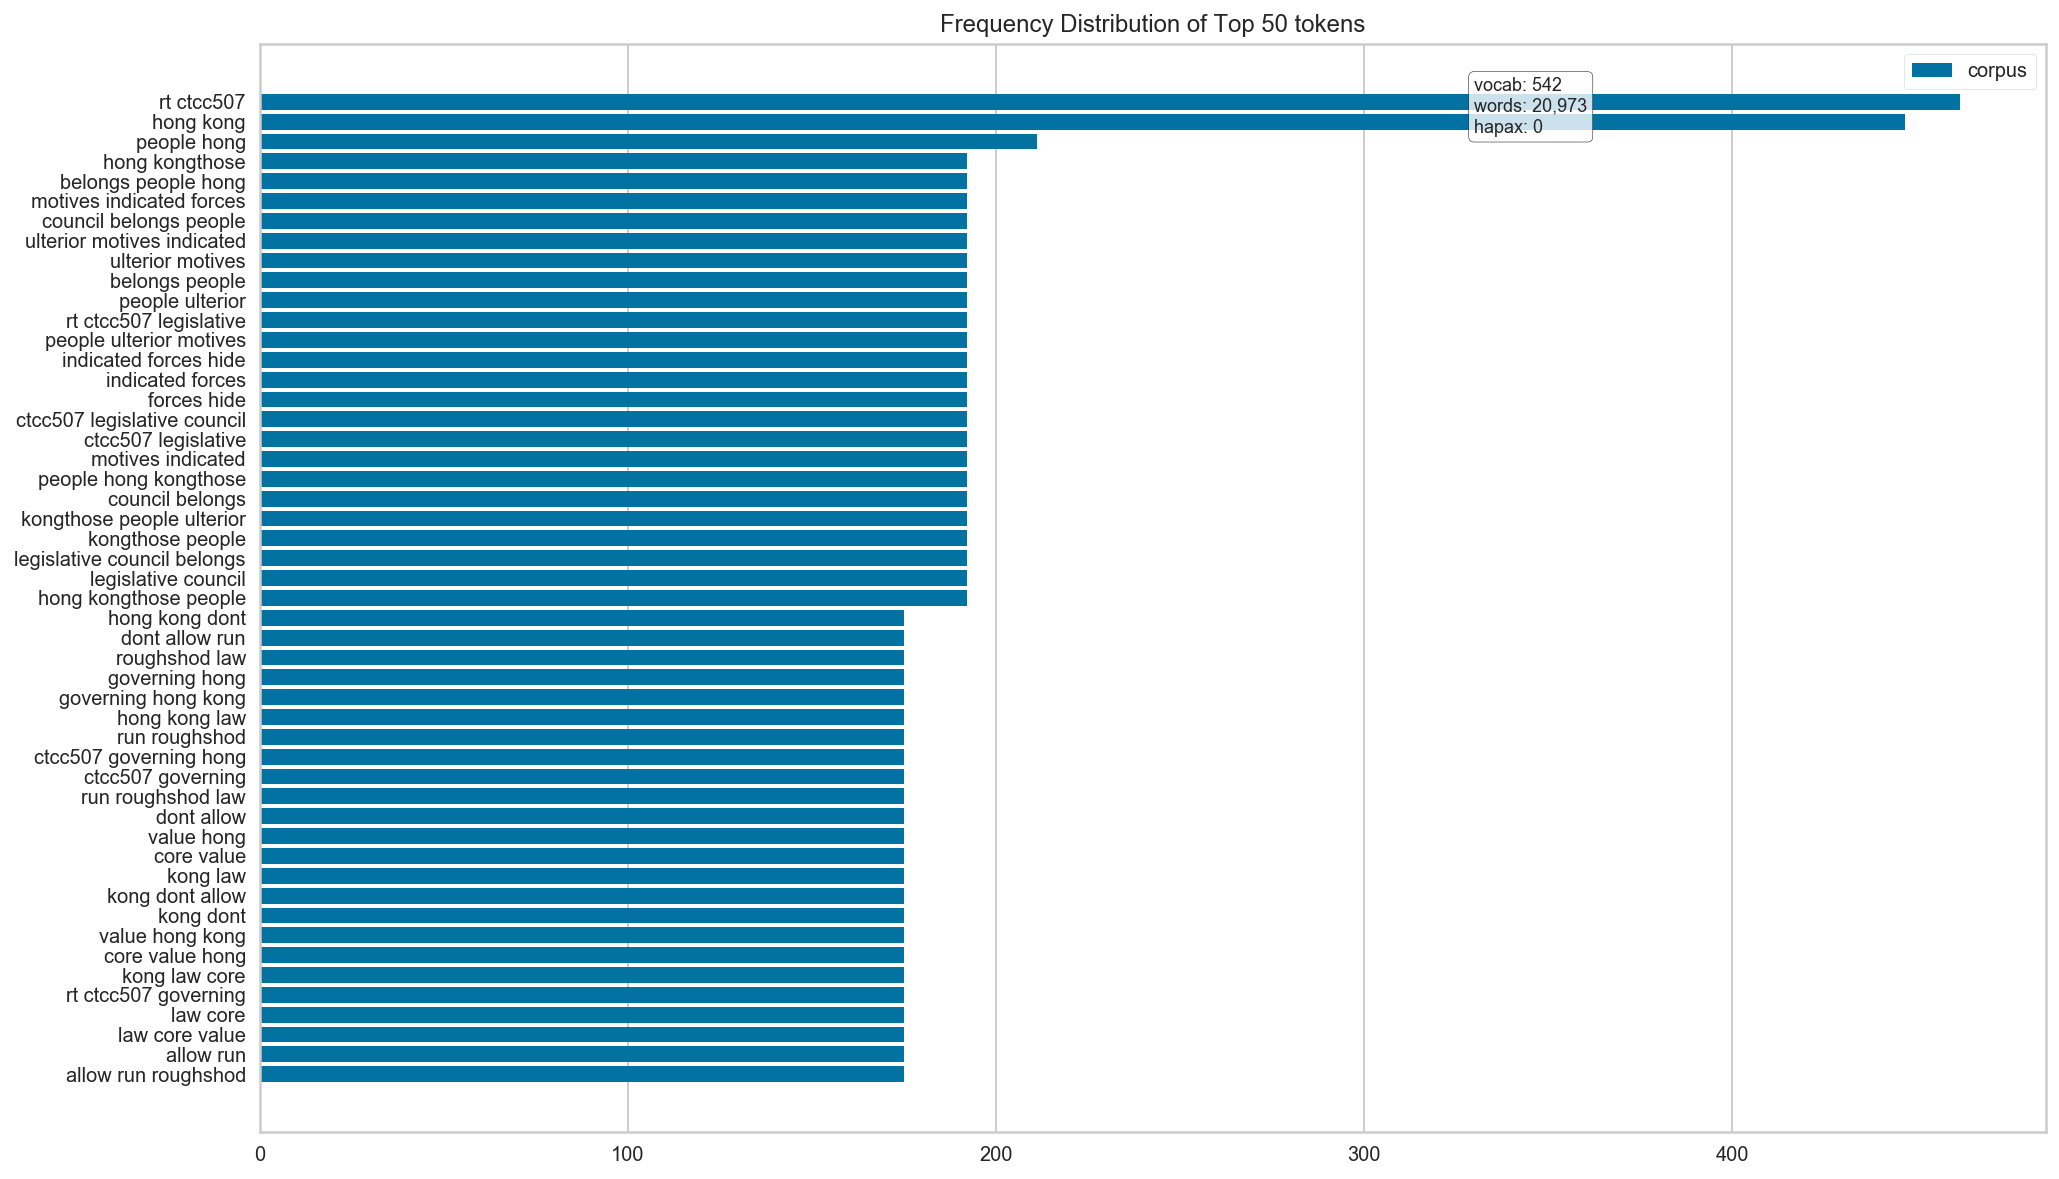

In [52]:
vect = CountVectorizer(
    tokenizer=lambda x: x.split(), stop_words="english", min_df=5, ngram_range=(2, 3)
)
docs = vect.fit_transform(surge_eng_rt["clean_tweet_text"].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

In [53]:
rt_ctcc = surge_eng_rt[surge_eng_rt["clean_tweet_text"].str.contains('ctcc507')]
rt_ctcc.shape

(465, 20)

In [54]:
rt_ctcc['tweet_text'].sample(5).values

array(['RT @ctcc507: The legislative council belongs to the people of Hong Kong.Those people with ulterior motives indicated by forces hide behind…',
       'RT @ctcc507: Governing Hong Kong by law is the core value of Hong Kong. We don’t allow anyone to run roughshod over the law. https://t.co/P…',
       'RT @ctcc507: Governing Hong Kong by law is the core value of Hong Kong. We don’t allow anyone to run roughshod over the law. https://t.co/P…',
       'RT @ctcc507: Governing Hong Kong by law is the core value of Hong Kong. We don’t allow anyone to run roughshod over the law. https://t.co/P…',
       'RT @ctcc507: Governing Hong Kong by law is the core value of Hong Kong. We don’t allow anyone to run roughshod over the law. https://t.co/P…'],
      dtype=object)

## NOTE:
@ctcc507 was retweeted 465 times in this small subset alone. The sample above leaves no doubt as to the messages the troll account was trying to push. 

Elsewhere in the retweets, we see the trolls continue to push the conspiracy theory about foreign intervention in the HK protests (several variations of 'ulterior motives' ranked near the top).

## 4.4 SCATTERTEXT PLOT FOR ENGLISH TWEETS AND RETWEETS DURING SURGE PERIOD
The visual value of the Scattertext plot wasn't high in this case, but I kept it for the useful search function within such plots. If you download the html file, you can use use the chart's search box to easily find tweets and retweets associated with the desired search terms, such as "ulterior motives".

This could be valuable for future research.

In [55]:
surge_eng['tweet_status'] = np.where(surge_eng["tweet_text"].str.startswith("RT"), "retweet", "tweet")

In [56]:
surge_eng['clean_tweet_text'] = surge_eng['tweet_text'].map(lambda tweet: clean_tweet(tweet))

In [57]:
# There are several options for spacy's pre-trained English models
# Go here if you wish to use a different one: https://spacy.io/models/en

nlp = spacy.load("en_core_web_lg") # to install, run: python -m spacy download en_core_web_lg

corpus = (st.CorpusFromPandas(
    surge_eng, 
    category_col="tweet_status", 
    text_col="clean_tweet_text", 
    nlp=nlp
).build().remove_terms(ENGLISH_STOP_WORDS, ignore_absences=True))

In [58]:
# This gives us the terms most associated with tweets and retweets in this subset:

term_freq_df = corpus.get_term_freq_df()
term_freq_df["Tweet Score"] = corpus.get_scaled_f_scores("tweet")
print(
    "Terms most associated with tweets:",
    list(term_freq_df.sort_values(by="Tweet Score", ascending=False).index[:10]),
)

term_freq_df["Retweet Score"] = corpus.get_scaled_f_scores("retweet")
print(
    "Terms most associated with retweets:",
    list(term_freq_df.sort_values(by="Retweet Score", ascending=False).index[:10]),
)



Terms most associated with tweets: ['fanatic', 'twitter myfirsttweet', 'setting up', 'just setting', 'myfirsttweet', 'setting', 'person', 'app', 'is not', 'web']
Terms most associated with retweets: ['governing', 'core value', 'to run', 'hongkong', 'hk', 'roughshod over', 'anyone to', 'allow anyone', 'run roughshod', 'the core']


In [59]:
# Change the minimum_term_frequency if you wish to filter more aggressively

html = st.produce_scattertext_explorer(
    corpus,
    category="tweet",
    category_name="Tweets",
    not_category_name="Retweets",
    width_in_pixels=1000,
    metadata=surge_eng["user_screen_name"],
    minimum_term_frequency=10,
    show_characteristic=False,
)

interactive = "../charts/surge_eng.html"
open(interactive, "wb").write(html.encode("utf-8"))

IFrame(src=interactive, width=1200, height=700)

# Download this from the "charts" folder in the repo 

## HOW TO INTERPRET A SCATTERTEXT CHART:

### Colour
 - The words in the chart are colored by their association. Those in blue are more associated with original tweets, while those in red are more associated with retweets. Each dot corresponds to a word or phrase mentioned.

### Positioning: 
- Words nearer the top of the plot represent the most frequently used words in the "original" tweets.

- The further right a dot, the more that word or phrase was used in retweets (eg: 'motives', or 'ctcc507', the name of a top troll account).

- Words that appear frequently in both tweets and rewteets, like "people" and "hong kong", appear in the upper-right-hand corner.

- Words that aren't often used in either tweets or retweets appear in the bottom-left-hand corner.


### Key Areas:
- Upper-left corner: These words appear frequently in the tweets but not the retweets. We still see a substantial amount of noise here, as evidenced by the appearance of words like "myfirsttweet" and "bacon" near the very top.

- Lower-right corner: Likewise, words which appear frequently in retweets but not the tweets appear in the lower right corner. 

## 4.5 KEY TERMS IN *CHINESE TWEETS & REWTEETS* TEXT
The far higher volume of Chinese tweets made it necessary for me to further narrow the focus of the subsequent sections. I'll focus only on the Chinese tweets in July, the largest chunk by far during the surge period of about 35,000 tweets.

And like in the case of the English troll content, retweets made up the bulk of Chinese language troll tweets.

In [60]:
surge_ch['tweet_month'].value_counts()

7    35471
6    15225
8     5251
5     4048
Name: tweet_month, dtype: int64

In [61]:
surge_ch_july = surge_ch[surge_ch['tweet_month'] == 7]

In [62]:
#Splitting the Chinese tweets in July into 2 - "original" tweets Vs retweets
surge_ch_july_no_rt = surge_ch_july[~surge_ch_july["tweet_text"].str.startswith("RT")].copy()

surge_ch_july_rt = surge_ch_july[surge_ch_july["tweet_text"].str.startswith("RT")].copy()

In [63]:
# Retweets made up 80% of the material in the July set of Chinese troll tweets 
surge_ch_july_no_rt.shape, surge_ch_july_rt.shape

((6756, 19), (28715, 19))

In [64]:
# Separate function to clean up the Chinese tweet text
def clean_tweet_ch(text):
    text = text.strip(" ")
    text = text.strip(r"\n")
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"http\S+", "", text)
    filtered = re.compile(u'[^\u4E00-\u9FA5]') # non-Chinese unicode range
    text = filtered.sub(r'', text) # remove all non-Chinese characters
    return text

In [65]:
surge_ch_july_no_rt['clean_tweet_text'] = surge_ch_july_no_rt['tweet_text'].map(lambda tweet: clean_tweet_ch(tweet))

surge_ch_july_rt['clean_tweet_text'] = surge_ch_july_rt['tweet_text'].map(lambda tweet: clean_tweet_ch(tweet))

In [66]:
#This list of stop words can be improved upon
jb_stopwords = [
    "的",
    "了",
    "和",
    "是",
    "就",
    "都",
    "而",
    "及",
    "與",
    "著",
    "或",
    "一個",
    "一",
    "個",
    "沒有",
    "我們",
    "你們",
    "妳們",
    "他們",
    "她們",
    "是否",
    "时间",
    "整点",
    "报时",
    "现在",
    "日电",
    "月",
    "日",
    "桂",
    "海",
    "在",
    "电",
    "欢乐",
    "习近平",
]

In [67]:
text = surge_ch_july_no_rt["clean_tweet_text"].values
text_list = []
for t in text:
    text_list.append(' '.join(jieba.cut(t, HMM=False)))
    
vect = CountVectorizer(
    tokenizer=lambda x: x.split(), stop_words=jb_stopwords, min_df=10, ngram_range=(2, 4)
)

docs_ch = vect.fit_transform(text_list)
features_ch = vect.get_feature_names()

count_list1 = pd.DataFrame(docs_ch.toarray(),
                       columns=features_ch).sum(axis=0)
count_list1.sort_values(ascending = False).head(50) 

Building prefix dict from /anaconda3/lib/python3.6/site-packages/jieba/dict.txt ...
Loading model from cache /var/folders/6z/wrz4dxdx65585cc04rbtr1xh0000gn/T/jieba.cache
Loading model cost 1.0432078838348389 seconds.
Prefix dict has been built succesfully.


反 對       314
社 會       277
對 派       248
反 對 派     248
瘟 龟       215
行 為       191
瘟 鬼       183
破 壞       178
香港 嘅      160
穩 定       158
香港 法治     151
佢 哋       148
严惩 暴徒     131
香港 警察     126
遊 行       120
嚴 懲       117
一定 要      116
應 該       114
维护 香港     108
勢 力       105
嘅 行       104
香港 和平     103
中 國       102
支持 香港      99
我 哋        98
香港 人       98
瘟 贵        97
警 隊        92
壞 香港       89
已 經        89
衝 擊        88
維 護        88
破 壞 香港     87
為 香港       84
香港 社       84
香港 社 會     84
破坏 香港      83
亂 香港       83
敢 於        81
國 家        80
為 咗        78
事 務        78
爱 港        77
嚴 重        76
郭 瘟        76
嘅 行 為      76
擾 亂        76
锅 瘟        75
修 例        75
繁 榮        73
dtype: int64

In [68]:
text = surge_ch_july_rt["clean_tweet_text"].values
text_list = []
for t in text:
    text_list.append(' '.join(jieba.cut(t, HMM=False)))
    
vect = CountVectorizer(
    tokenizer=lambda x: x.split(), stop_words=jb_stopwords, min_df=10, ngram_range=(2, 4)
)

docs_ch = vect.fit_transform(text_list)
features_ch = vect.get_feature_names()

count_list2 = pd.DataFrame(docs_ch.toarray(),
                       columns=features_ch).sum(axis=0)
count_list2.sort_values(ascending = False).head(50) 

逃犯 条例          8182
香港 逃犯          7951
香港 逃犯 条例       7299
逃犯 条例 游行       6132
条例 游行          6132
香港 逃犯 条例 游行    5695
護 香港           4751
遊 行            4535
社 會            4257
反 對            4131
游行 暴徒          3885
守 護            3738
逃犯 条例 游行 暴徒    3354
条例 游行 暴徒       3354
反 對 派          3153
對 派            3153
守 護 香港         3011
行 為            2996
破 壞            2595
警 員            2572
衝 擊            2568
立法 會           2187
反修 例           2106
維 護            2080
穩 定            2048
譴 責            2046
修 例            2040
香港 法治          2012
條 例            1951
逃犯 條           1926
逃犯 條 例         1925
我 哋            1922
執 法            1899
警 隊            1863
香港 警察          1825
衝 突            1615
港 獨            1584
繁 榮            1571
唔 好            1510
香港 人           1489
集 會            1448
我 們            1423
民 眾            1391
變 成            1378
應 該            1372
佢 哋            1367
破坏 香港          1364
香港 嘅           1361
維 護 香港         1342
違 法            1302


## NOTE:

What I've noticed from the term frequency counts above and a weekend of looking through the tweets is the higher usage of terms condemning the protestors who turned violent. The term 暴徒 (violent thugs) and the call to punish the violent protestors (严惩 暴徒) came up more prominently in the second tranche of tweets, compared to the first.

But a fuller content analysis is needed to confirm if this indeed reflected a change in "narrative" focus in the disinformation campaign.

## 4.6 SCATTERTEXT PLOT FOR CHINESE TWEETS AND RETWEETS BY 2 TOP TROLLS
The Scattertext plots for a large corpora of Chinese text result in huge file sizes and as a result are mostly unuseable on consumer-level computers. So for practical reason, I opted to focus just on the Chinese tweets of just 2 top trolls in the second tranche of state troll tweets - @bindarsou and @hk_observer. Both were retweeted regularly by the less active troll accounts, and account for about 45k tweets between them. @bindarsou is by far the larger of the two accounts. 

In [69]:
ch_trolls = ["bindarsou", "hk_observer"]

In [70]:
top_ch_trolls = raw_sept[raw_sept['user_screen_name'].isin(ch_trolls)]

In [71]:
top_ch_trolls['user_screen_name'].value_counts()

bindarsou      36576
hk_observer     8357
Name: user_screen_name, dtype: int64

In [72]:
top_ch_trolls['tweet_status'] = np.where(top_ch_trolls["tweet_text"].str.startswith("RT"), "retweet", "tweet")

In [73]:
top_ch_trolls['clean_tweet_text'] = top_ch_trolls['tweet_text'].map(lambda tweet: clean_tweet_ch(tweet))
top_ch_trolls['clean_tweet_text'] = top_ch_trolls['clean_tweet_text'].apply(chinese_nlp)

In [74]:
corpus = CorpusFromParsedDocuments(
    top_ch_trolls, category_col="tweet_status", parsed_col="clean_tweet_text"
).build()

term_freq_df = corpus.get_term_freq_df()

term_freq_df["Tweet Score"] = corpus.get_scaled_f_scores("tweet")
print(
    "Terms most associated with trolls' tweets (Chinese):",
    list(term_freq_df.sort_values(by="Tweet Score", ascending=False).index[:10]),
)

term_freq_df["Retweet Score"] = corpus.get_scaled_f_scores("retweet")
print(
    "Terms most associated with trolls' retweets (Chinese):",
    list(term_freq_df.sort_values(by="Retweet Score", ascending=False).index[:10]),
)

Terms most associated with trolls' tweets (Chinese): ['反修 例', '守護', '穩定', '中文', '特區', '武器', '港人', '守護 香港', '例', '組織']
Terms most associated with trolls' retweets (Chinese): ['一种', '暴动', '我们', '什么', '议员', '川普', '港灿们', '因为', '会', '来']


In [75]:
html = produce_scattertext_explorer(
    corpus,
    category="tweet",
    category_name="Tweets",
    not_category_name="Retweets",
    width_in_pixels=1000,
    metadata=top_ch_trolls["user_screen_name"],
    asian_mode=True,
    show_characteristic=False,
)

interactive = "../charts/surge_top_trolls.html"
open(interactive, "w").write(html)

IFrame(src=interactive, width=1200, height=700)

## INTERPRETING THE CHINESE SCATTERTEXT CHART:

### Colour
 - The words in the chart are colored by their association. Those in blue are more associated with original tweets, while those in red are more associated with retweets. Each dot corresponds to a word or phrase mentioned.

### Positioning: 

- Words that appear frequently in both tweets and rewteets, like "香港"(Hong Kong) and "暴力"(violence), appear in the upper-right-hand corner, reflecting Beijing's main line of criticisms against the protests. 

- Words nearer the top of the plot represent the most frequently used words in the "original" tweets. 


### Key Areas:
- Upper-left corner: These words appear frequently in the tweets but not the retweets. 

- Lower-right corner: Likewise, words which appear frequently in retweets but not the tweets appear in the lower right corner. 

Download the chart from the repo's "charts" folder for a fuller look. Use the search box at the bottom of the chart to see how the word was used in the tweets and retweets by the various users in the subset. 